# Comparison between cluster of controls and cluster of patients (CAD)

### Controls in the same size as cases are considered (same age/gender division), clustering, gene/pathways and endophenotype analysis are repeated. 
Sample preparation: 
- Controls are extracted from CAD_SOFT == 0
- Samples with family history (mother father or siblings) of heart disease and stroke are removeed
- Control samples are matched per age and sex with cases, total of 19032 with 14690 males and 4332 females

Analysis:
- Do we find a relationship between phenotype and cluster-associated genes / pathways? --> for each pair of groups, compute the correlation of estimates WMW.
- What are the associated endophenotypes? How many? What is the reference?
- clust internal cluster performance

In [1]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(clustAnalytics)
library(rlist)
library(ggsci)
library(stringr)
library(corrplot)
library(RColorBrewer)
library(VennDiagram)
library(ggpubr)


options(bitmapType = 'cairo', device = 'png')

fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
outFold <- sprintf('%sCAD_clustering/', fold_notebook)

setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
fold <- "OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/"

out_cases <- get(load(sprintf('%s/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', fold)))
out_controls <- get(load(sprintf('%s/tscore_corrPCs_zscaled_clusterControls_PGmethod_HKmetric.RData', fold)))
out_controls_original <- get(load(sprintf('%s/tscore_corrPCs_original_clusterControls_PGmethod_HKmetric.RData', fold)))

gene_cases <- get(load(sprintf('%s/tscoreOriginal_corrPCs_tscoreClusterCases_featAssociation.RData', fold)))
gene_controls <- get(load(sprintf('%s/tscoreOriginal_corrPCs_tscoreClusterControls_featAssociation.RData', fold)))
gene_controls_original <- get(load(sprintf('%s/ClusterOriginal_tscoreOriginal_corrPCs_tscoreClusterControls_featAssociation.RData', fold)))

path_cases <- get(load(sprintf('%s/pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData', fold)))
path_controls <- get(load(sprintf('%s/pathOriginal_filtJS0.2_corrPCs_tscoreClusterControls_featAssociation.RData', fold)))
path_controls_original <- get(load(sprintf('%s/ClusterOriginal_pathOriginal_filtJS0.2_corrPCs_tscoreClusterControls_featAssociation.RData', fold)))

endop_cases <- read_tsv(sprintf('%s/filter_endopheno/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_combined_keepPhenoClass.txt', fold), show_col_types = FALSE)
endop_controls <- read_tsv(sprintf('%s/filter_endopheno/tscore_corrPCs_zscaled_clusterControls_PGmethod_HKmetric_phenoAssociation_GLM_combined_keepPhenoClass.txt', fold), show_col_types = FALSE)
endop_controls_original <- read_tsv(sprintf('%s/filter_endopheno/tscore_corrPCs_original_clusterControls_PGmethod_HKmetric_phenoAssociation_GLM_combined_keepPhenoClass.txt', fold), show_col_types = FALSE)

colorFile <- sprintf('%scolor_pheno_type_UKBB.txt', fold_notebook)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.5
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘clustAnalytics’


The following object is masked from ‘package:ggp

In [74]:
#### plot cluster distributions
plot_stat_cases_controls <- function(cases, controls, outFold, name_comp_controls = "Controls", width_pl = 3, height_pl = 5){

cl_measure_ca <- cases$info_tune$coverage_and_conductance
cl_measure_co <- controls$info_tune$coverage_and_conductance

tmp_ca <- data.frame(type = rep("Cases", cases$info_tune$n_clusters), 
                     n_samples = sapply(sort(unique(cases$cl_best$gr)), function(x) sum(cases$cl_best$gr == x)), 
                     gr = sort(unique(cases$cl_best$gr)))

tmp_co <- data.frame(type = rep("Controls", controls$info_tune$n_clusters), 
                     n_samples = sapply(sort(unique(controls$cl_best$gr)), function(x) sum(controls$cl_best$gr == x)), 
                     gr = sort(unique(controls$cl_best$gr)))

df <- rbind(tmp_ca, tmp_co)
df$gr <- paste0('gr', df$gr)
max_gr <- max(as.numeric(sapply(unique(as.character(df$gr)), function(x) strsplit(x, 'gr')[[1]][2])))
df$gr <- factor(df$gr, levels = paste0('gr', 1:max_gr))

if(length(unique(df$gr)) > 20){
    getPalette <- colorRampPalette(pal_d3("category20")(20))
    color_gr <- getPalette(length(levels(df$gr)))
}else{
    color_gr <- pal_d3("category20")(length(levels(df$gr)))
}

n_samples_tot <- df %>% group_by(type) %>% summarise(n_samples_tot = sum(n_samples)) %>% pull(n_samples_tot) %>% max()

pl <- ggplot(data = df, aes(x = type, y = n_samples, fill = gr))+
    geom_bar(alpha = 0.7, width = 0.5, stat = 'identity', color = "black")+
    ylab('n. samples')+ 
    theme_bw()+ 
    geom_text(inherit.aes = FALSE, 
              data = data.frame(type = c('Cases', 'Controls'), 
                                n_samples = rep(n_samples_tot,2), 
                                coverage_and_conductance = c(cl_measure_ca, cl_measure_co)), 
              aes(x = type, y = n_samples, label = paste0("Cl. quality:\n", round(coverage_and_conductance, 3))), 
              vjust = -0.5, hjust = 0.5, size = 3, color = 'black')+
    theme(legend.position = 'right', axis.title.x = element_blank(),
          legend.text = element_text(size = 8), legend.title = element_blank())+
    ylim(c(0, n_samples_tot + 1000))+
    scale_fill_manual(values = color_gr)+
    guides(fill = guide_legend(ncol = max(1, round(length(levels(df$gr))/10))))

print(pl)

ggsave(filename = sprintf('%scompare_Cases_%s_dist_clusters.pdf', outFold, name_comp_controls), 
       plot = pl, width = width_pl, height = height_pl)

return(df)

}

#### plot correlation WMW t-scores and pathscores across tissues
plot_corr_feat <- function(cases, controls, outFold, type_data, name_comp_controls = "Controls", width_pl = 5, height_pl = 5){

comp_cases <- sort(unique(cases$test_feat[[1]]$comp))
comp_controls <- sort(unique(controls$test_feat[[1]]$comp))

# split comp column by _vs_all with stringr package

feat_cases <- lapply(cases$test_feat, function(x) 
    x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))) %>%
    bind_rows() 

feat_controls <- lapply(controls$test_feat, function(x) x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))) %>%
    bind_rows() 

feat_tot <- rbind(feat_cases, feat_controls)
comp_all <- unique(feat_tot$comp_type)
comp_cases <- unique(feat_cases$comp_type)
comp_controls <- unique(feat_controls$comp_type)

cor_mat <- matrix(nrow = length(comp_cases), ncol = length(comp_controls))
colnames(cor_mat) <- comp_controls
rownames(cor_mat) <- comp_cases
pval_mat <- cor_mat

for(i in 1:length(comp_cases)){
    ci_cases <- comp_cases[i]
    vi <- feat_tot %>% filter(comp_type == ci_cases) 
    for(j in 1:length(comp_controls)){
        cj_controls <- comp_controls[j]
        vj <- feat_tot %>% filter(comp_type == cj_controls) 
        # check order is correct
        if(!identical(vi$feat_tissue, vj$feat_tissue)){stop(sprintf('Order of feat_tissue is not the same in %s and %s', ci_cases, cj_controls))}
        cor_mat[i,j] <- cor(vi$estimates, vj$estimates, method = 'pearson')
        pval_mat[i,j] <- cor.test(vi$estimates, vj$estimates, method = 'pearson')$p.value
    }
}

pdf(file = sprintf('%scorr_%s_comapre_Cases_%s.pdf', outFold, type_data, name_comp_controls), 
    width = width_pl, height = height_pl, compress = F, pointsize = 12)
    corrplot(cor_mat, 
     sig.level = 0.05, 
        p.mat = pval_mat,
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0), 
         col.lim=c(-1, 1))
dev.off()

# plot NMI
corrplot(cor_mat, 
 sig.level = 0.05, 
        p.mat = pval_mat,
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0), 
         col.lim=c(-1, 1))

return(list(cor = cor_mat))

}


#### plot intersection of cluster-specific genes/pathways
plot_intersection <- function(
  cases, 
  controls, 
  outFold, 
  pval_corr_thr = 0.01, 
  type_data, 
  name_comp_controls = "Controls", 
  width_pl = 5, 
  height_pl = 5){

comp_cases <- sort(unique(cases$test_feat[[1]]$comp))
comp_controls <- sort(unique(controls$test_feat[[1]]$comp))

feat_sign_cases <- lapply(cases$test_feat, function(x) 
    x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(type = "Cases") %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr)) %>%
    bind_rows()


feat_sign_controls <- lapply(controls$test_feat, function(x) 
    x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(type = "Controls") %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr)) %>%
    bind_rows() 

feat_sign_tot <- rbind(feat_sign_cases, feat_sign_controls)

common_feat <- intersect(unique(feat_sign_cases$feat_tissue), unique(feat_sign_controls$feat_tissue))

df <- feat_sign_tot %>% 
    mutate(common = case_when(feat_tissue %in% common_feat ~ 'common', TRUE ~ 'unique'))
df$common <- factor(df$common, levels = c('unique', 'common'))

futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

tmp <- venn.diagram(list(Cases = unique(feat_sign_cases$feat_tissue), Controls = unique(feat_sign_controls$feat_tissue)), 
  fill = c("red", "blue"),
  alpha = c(0.5, 0.5), 
  lty = 2,
  filename = NULL, 
  lwd = 1,
  cex = 2,
  cat.cex = 2)
pdf(file = sprintf('%sVenn_sign%s_Cases_%s.pdf', outFold, type_data, name_comp_controls), 
    width = 3, height = 3)
    grid.draw(tmp)
dev.off()
grid.draw(tmp)

type_data_pl <- ifelse(type_data == 'Tscores', 'genes', 'pathways')
# add boxplot of estimates from df, divide per common/unique, use ggplot2
pl <- ggplot(data = df, aes(x = common, y = abs(estimates)))+
    geom_boxplot(outlier.size = 0.5)+
    stat_compare_means(method = 'wilcox.test', label = 'p.format', label.x = 1.5, size = 3)+
    facet_wrap(~type, ncol = 2)+
    theme_bw()+ 
    xlab(sprintf('Cluster-specific %s', type_data_pl)) + 
    ylab('|WMW estimates|')+
    theme(legend.position = 'none')
print(pl)
# save plot
ggsave(filename = sprintf('%sboxplot_sign%s_Cases_%s_common.pdf', outFold, type_data, name_comp_controls), 
       plot = pl, width = width_pl, height = height_pl)


}

# endophenotype plot
endopheno_forest_plot <- function(colorFile, res_pheno, pval_pheno = 0.0001, pval_corr_thr = 0.05, outFold, type_input, type_cluster) { 

    pheno_ann <- read.delim(colorFile, header = T, stringsAsFactors = F)

    id_keep <- unique(res_pheno$pheno_id[res_pheno$pvalue <= pval_pheno | res_pheno$pval_corr <= pval_corr_thr])
    id_keep <- id_keep[!is.na(id_keep)]
    df_red <- res_pheno %>% filter(pheno_id %in% id_keep) %>% 
        mutate(new_id = case_when(Field == "Diagnoses - ICD10" & !is.na(meaning)  ~ meaning, 
                                  grep("Illnesses", Field) & !is.na(meaning) ~ paste(Field, meaning, sep = ': '), 
                                  is.na(meaning) ~ paste(Field), 
                                  TRUE ~ paste(Field, meaning, sep = '\n'))) %>%
        mutate(sign = ifelse(pval_corr <= pval_corr_thr, 'yes', 'no')) %>%
        mutate(type_res = ifelse(type_pheno == 'CONTINUOUS', 'beta', 'OR')) %>%
        mutate(OR_or_Beta = ifelse(se_beta > 100, NA, OR_or_Beta)) %>%
        mutate(CI_low = ifelse(se_beta > 100, NA, CI_low)) %>% 
        mutate(CI_up = ifelse(se_beta > 100, NA, CI_up))
  
    df_red$new_id <- factor(df_red$new_id, levels = unique(df_red$new_id))
    df_red$comp <- factor(df_red$comp, levels = unique(df_red$comp))
    df_red$pheno_type <- factor(df_red$pheno_type, levels = unique(df_red$pheno_type))
    df_red$sign <- factor(df_red$sign, levels = c('no', 'yes'))
    df_red$type_res <- factor(df_red$type_res, levels = c('OR', 'beta'))

    df_red_for_ann <- df_red[!duplicated(df_red$new_id),]
    pheno_ann_red1 <- pheno_ann[match(df_red_for_ann$pheno_type[df_red_for_ann$type_pheno != 'CONTINUOUS'], pheno_ann$pheno_type), ,drop = F]
    pheno_ann_red2 <- pheno_ann[match(df_red_for_ann$pheno_type[df_red_for_ann$type_pheno == 'CONTINUOUS'], pheno_ann$pheno_type), ,drop = F]

    len_w <- length(unique(df_red$comp))
    len_h <- length(unique(df_red$pheno_id))
    # change labels 
    labs_new <- sapply(as.character(unique(df_red$comp)), function(x) strsplit(x, split = '_vs_all')[[1]][1])
    names(labs_new) <- as.character(unique(df_red$comp))
  
  P <- length(unique(df_red$comp))
  if(P > 20){
    getPalette <- colorRampPalette(pal_d3("category20")(20))
    gr_color <- getPalette(P)
  }else{
    gr_color <- pal_d3("category20")(P)
  }

    if(any(df_red$type_pheno != 'CONTINUOUS')){
    
    pl_OR <-  ggplot(subset(df_red, type_pheno != 'CONTINUOUS'), aes(x = new_id, y = OR_or_Beta, shape = sign))+
      geom_point()+geom_errorbar(aes(ymin=CI_low, ymax=CI_up), width=.2, position=position_dodge(0.05))+
      theme_bw()+ 
      ylab('Adjusted OR (95% CI)')+ geom_hline(yintercept = 1, linetype = 'dashed', color = 'grey40')+
      facet_wrap(comp~.,  nrow = 1, strip.position="top", labeller = labeller(comp = labs_new))+
      theme(legend.position = 'none', 
            plot.title = element_text(size=9), 
            axis.title.y = element_blank(), 
            axis.title.x = element_text(size=8),
            axis.text.x = element_text(size = 7, angle = 45, hjust = 1), 
            axis.text.y = element_text(size = 7, colour = pheno_ann_red1$color, face = pheno_ann_red1$face),
            strip.text = element_text(size=8, color = 'white', face = 'bold'))+
      scale_shape_manual(values=c(1, 19))+
      scale_color_manual(values=pheno_ann_red1$color)+
      scale_y_continuous(trans='log', labels = scales::number_format(accuracy = 0.01))+
      coord_flip()
    
    pl_OR <- ggplot_gtable(ggplot_build(pl_OR))
    stripr <- which(grepl('strip-t', pl_OR$layout$name))
    fills <- gr_color
    k <- 1
        for (i in stripr) {
      j <- which(grepl('rect', pl_OR$grobs[[i]]$grobs[[1]]$childrenOrder))
      pl_OR$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
      k <- k+1
    }
  }
  
  if(any(df_red$type_pheno == 'CONTINUOUS')){
    
    pl_beta <-  ggplot(subset(df_red, type_pheno == 'CONTINUOUS'), aes(x = new_id, y = OR_or_Beta, shape = sign))+
      geom_point()+geom_errorbar(aes(ymin=CI_low, ymax=CI_up), width=.2, position=position_dodge(0.05))+
      theme_bw()+ 
      ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
      facet_wrap(comp~., nrow = 1, strip.position="top",  labeller = labeller(comp = labs_new))+
      theme(legend.position = 'none', 
            plot.title = element_text(size=9), 
            axis.title.y = element_blank(), 
            axis.title.x = element_text(size=8),
            axis.text.x = element_text(size = 7, angle = 45, hjust = 1), 
            axis.text.y = element_text(size = 7,  colour = pheno_ann_red2$color, face = pheno_ann_red2$face), 
            strip.text = element_text(size=8, color = 'white', face = 'bold'))+
      scale_shape_manual(values=c(1, 19))+
      scale_color_manual(values=pheno_ann_red2$color)+
      coord_flip()

    sum_c <- sum(df_red$type_pheno == 'CONTINUOUS')
    sum_notc <- sum(df_red$type_pheno != 'CONTINUOUS')

    ratio_OR_beta <- ifelse(sum_c > sum_notc, (sum_notc)/sum_c + 0.2, (sum_c)/sum_notc + 0.2)
    print(ratio_OR_beta)

    pl_beta <- ggplot_gtable(ggplot_build(pl_beta))
    stripr <- which(grepl('strip-t', pl_beta$layout$name))
    fills <- gr_color
    k <- 1
        for (i in stripr) {
      j <- which(grepl('rect', pl_beta$grobs[[i]]$grobs[[1]]$childrenOrder))
      pl_beta$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
      k <- k+1
    }
  }
  
  if(any(df_red$type_pheno == 'CONTINUOUS') & any(df_red$type_pheno != 'CONTINUOUS')){
    if(sum_c > sum_notc){
      heights_tmp = c(1, ratio_OR_beta)
    }else{
      heights_tmp = c(ratio_OR_beta, 1)
    }
    tot_pl <- ggarrange(plotlist = list(pl_beta, pl_OR), align = 'v', ncol = 1, heights = heights_tmp)
  }else{
    if(any(df_red$type_pheno == 'CONTINUOUS')){
      tot_pl <- pl_beta
    }else{
      tot_pl <- pl_OR
    }
  }

  ggsave(filename = sprintf('%stscore_%s_cluster%s_PGmethod_HKmetric_phenoAssociation_GLM_betaOR_Integrated.pdf', outFold, type_input, type_cluster), 
         width = len_w*0.8+4, height = len_h*0.2+1, plot = tot_pl, device = 'pdf')

      return(tot_pl)
}



#### plot correlation beta endophenotypes (only in common for each pair of groups)
plot_corr_pheno <- function(cases, controls, outFold, name_comp_controls = "Controls", width_pl = 5, height_pl = 5){

pheno_cases <- cases %>%
        mutate(type = "Cases") %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))


pheno_controls <- controls %>%
        mutate(type = "Controls") %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))

pheno_tot <- rbind(pheno_cases, pheno_controls)
comp_all <- unique(pheno_tot$comp_type)
comp_cases <- unique(pheno_cases$comp_type)
comp_controls <- unique(pheno_controls$comp_type)

cor_mat <- matrix(nrow = length(comp_cases), ncol = length(comp_controls))
colnames(cor_mat) <- comp_controls
rownames(cor_mat) <- comp_cases
pval_mat <- cor_mat

for(i in 1:length(comp_cases)){
    ci_cases <- comp_cases[i]
    vi <- pheno_tot %>% filter(comp_type == ci_cases) %>% filter(!is.na(beta), se_beta < 100)
    for(j in 1:length(comp_controls)){
        cj_controls <- comp_controls[j]
        vj <- pheno_tot %>% filter(comp_type == cj_controls) %>% filter(!is.na(beta), se_beta < 100)
        # check order is correct
        if(!identical(vi$pheno_id, vj$pheno_id)){
                p_common <- intersect(vi$pheno_id, vj$pheno_id)
                print(sprintf('N. common pheno for %s and %s = %i', ci_cases, cj_controls, length(p_common)))
                vi_new <-  vi[match(p_common, vi$pheno_id),]
                vj_new <-  vj[match(p_common, vj$pheno_id),]
        }else{
                vi_new <- vi
                vj_new <- vj
        }
        cor_mat[i,j] <- cor(vi_new$beta, vj_new$beta, method = 'pearson')
        pval_mat[i,j] <- cor.test(vi_new$beta, vj_new$beta, method = 'pearson')$p.value
    }
}


pdf(file = sprintf('%scorr_Endopheno_comapre_Cases_%s.pdf', outFold, name_comp_controls), 
    width = width_pl, height = height_pl, compress = F, pointsize = 12)
    corrplot(cor_mat, 
        sig.level = 0.05, 
        p.mat = pval_mat,
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0), 
         col.lim=c(-1, 1))
dev.off()

# plot NMI
corrplot(cor_mat, 
        tl.col = "black", # text color
        sig.level = 0.05, 
        p.mat = pval_mat,
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0), 
         col.lim=c(-1, 1))

return(list(cor = cor_mat))

}


# plot endophenotype results

plot_intersection_endop <- function(
      
  cases, 
  controls, 
  outFold, 
  pval_corr_thr = 0.05, 
  name_comp_controls = "Controls", 
  width_pl = 5, 
  height_pl = 5){
        

        common_pheno <- intersect(unique(cases$pheno_id), unique(controls$pheno_id))
        un_p <- setdiff(unique(cases$pheno_id), common_pheno)
        cases_unique = cases[cases$pheno_id %in% un_p,]
        print(table(cases_unique[!duplicated(cases_unique$pheno_id),"pheno_type"]))

        comp_cases <- sort(unique(cases$comp))
        comp_controls <- sort(unique(controls$comp))

        pheno_sign_cases <- cases %>%
        mutate(type = "Cases") %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr) 

        pheno_sign_controls <- controls %>%
        mutate(type = "Controls") %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr) 

        futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
        tmp <- venn.diagram(list(Cases = unique(pheno_sign_cases$pheno_id), Controls = unique(pheno_sign_controls$pheno_id)), 
        fill = c("red", "blue"),
        alpha = c(0.5, 0.5), 
        lty = 2,
        filename = NULL, 
        lwd = 1,
        cex = 2,
        cat.cex = 2)
        grid.draw(tmp)

        pdf(file = sprintf('%sVenn_signEndopheno_Cases_%s.pdf', outFold, name_comp_controls),  width = 3, height = 3)
        grid.draw(tmp)
        dev.off()

        common_sign_pheno <- intersect(unique(pheno_sign_cases$pheno_id), unique(pheno_sign_controls$pheno_id))
        tmp <- pheno_sign_cases[pheno_sign_cases$pheno_id %in% common_sign_pheno,]
        print(tmp[!duplicated(tmp$pheno_id), c("Field", "meaning")])

  }
  ### plot endopheno zstat 
  plot_scatter_endopzstat <- function(cases, controls, df_comparison, outFold){

pheno_cases <- cases %>%
        mutate(type = "Cases") %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(!is.na(beta), se_beta < 100)

pheno_controls <- controls %>%
        mutate(type = "Controls") %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(!is.na(beta), se_beta < 100)

pheno_tot <- rbind(pheno_cases, pheno_controls)
pl <- list()
for(i in 1:nrow(df_comparison)){
        print(i)
        tmp_controls <- pheno_tot %>% 
                filter(comp_type == paste0('Controls_gr', df_comparison$gr_controls[i])) %>% 
                select(pheno_id, Field, meaning, beta, se_beta, z, pvalue, pval_corr)
        tmp_cases <- pheno_tot %>% 
                filter(comp_type == paste0('Cases_gr', df_comparison$gr_cases[i])) %>% 
                select(pheno_id, Field, meaning, beta, se_beta, z, pvalue, pval_corr)
        tmp <- inner_join(tmp_cases, tmp_controls, by = c('pheno_id', 'Field', 'meaning'), suffix = c('_cases', '_controls')) %>%
                mutate(sign = case_when(pval_corr_cases <= 0.1 & pval_corr_controls <= 0.1 ~ 'both', 
                                        pval_corr_cases <= 0.1 & pval_corr_controls > 0.1 ~ 'only cases', 
                                        pval_corr_cases > 0.1 & pval_corr_controls <= 0.1 ~ 'only controls', 
                                        TRUE ~ 'none')) %>%
                mutate(sign = factor(sign, levels = c('none', 'both','only cases', 'only controls'))) %>%
                arrange(sign)

        pl[[i]] <- ggplot(data = tmp, aes(x = beta_cases, y = beta_controls, color = sign))+
                geom_point(alpha = 0.5)+
                geom_vline(xintercept = 0, color = 'grey40', linetype = 'dashed') +
                geom_hline(yintercept = 0, color = 'grey40', linetype = 'dashed')+
                theme_bw()+
                scale_color_manual(values = c('both' = 'violet', 'only cases' = 'red', 'only controls' = 'blue', 'none' = 'grey40'))+
                xlab('Adjusted Beta Cases')+
                ylab('Adjusted Beta Controls')+
                ggtitle(sprintf('Cases gr%i vs Controls gr%i', df_comparison$gr_cases[i], df_comparison$gr_controls[i]))+
                theme(legend.position = 'bottom', legend.title = element_blank(),plot.title = element_text(size = 10))
        print(tmp %>% filter(sign == 'both') %>% pull(Field))
}               
pl_tot <- ggarrange(plotlist = pl, ncol = 5, nrow = 1, align = 'hv', common.legend = TRUE, legend = 'bottom')
print(pl_tot)
ggsave(filename = sprintf('%sendopheno_beta_scatterplot_comparison_Cases_vs_Controls.pdf', outFold), 
         width = 12, height = 3, plot = pl_tot, device = 'pdf')

}

type,n_samples,gr
<chr>,<int>,<fct>
Cases,6105,gr1
Cases,4783,gr2
Cases,2831,gr3
Cases,4520,gr4
Cases,784,gr5
Controls,6682,gr1
Controls,2330,gr2
Controls,4288,gr3
Controls,4739,gr4


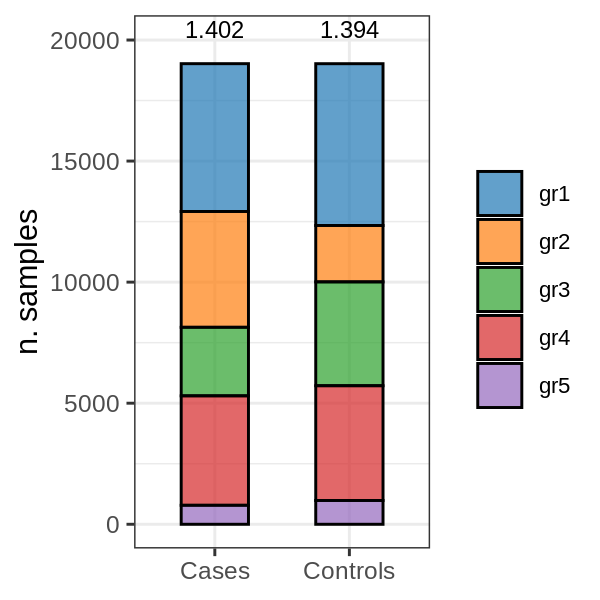

In [3]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 200)
plot_stat_cases_controls(out_cases, out_controls, outFold, name_comp_controls = "Controls", width_pl = 3, height_pl = 3)


,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5
Cases_gr1,0.77038143,-0.07328175,-0.18420292,-0.2923858,0.74443300
Cases_gr2,-0.06969135,0.01588216,-0.86860301,0.9192241,-0.06689806
Cases_gr3,-0.07205197,0.92698519,-0.05038212,-0.0215378,-0.06895577
Cases_gr4,-0.11710735,-0.12003263,0.93229650,-0.8439497,-0.11564780
Cases_gr5,0.71928812,-0.06227492,-0.22354093,-0.2233825,0.71985307


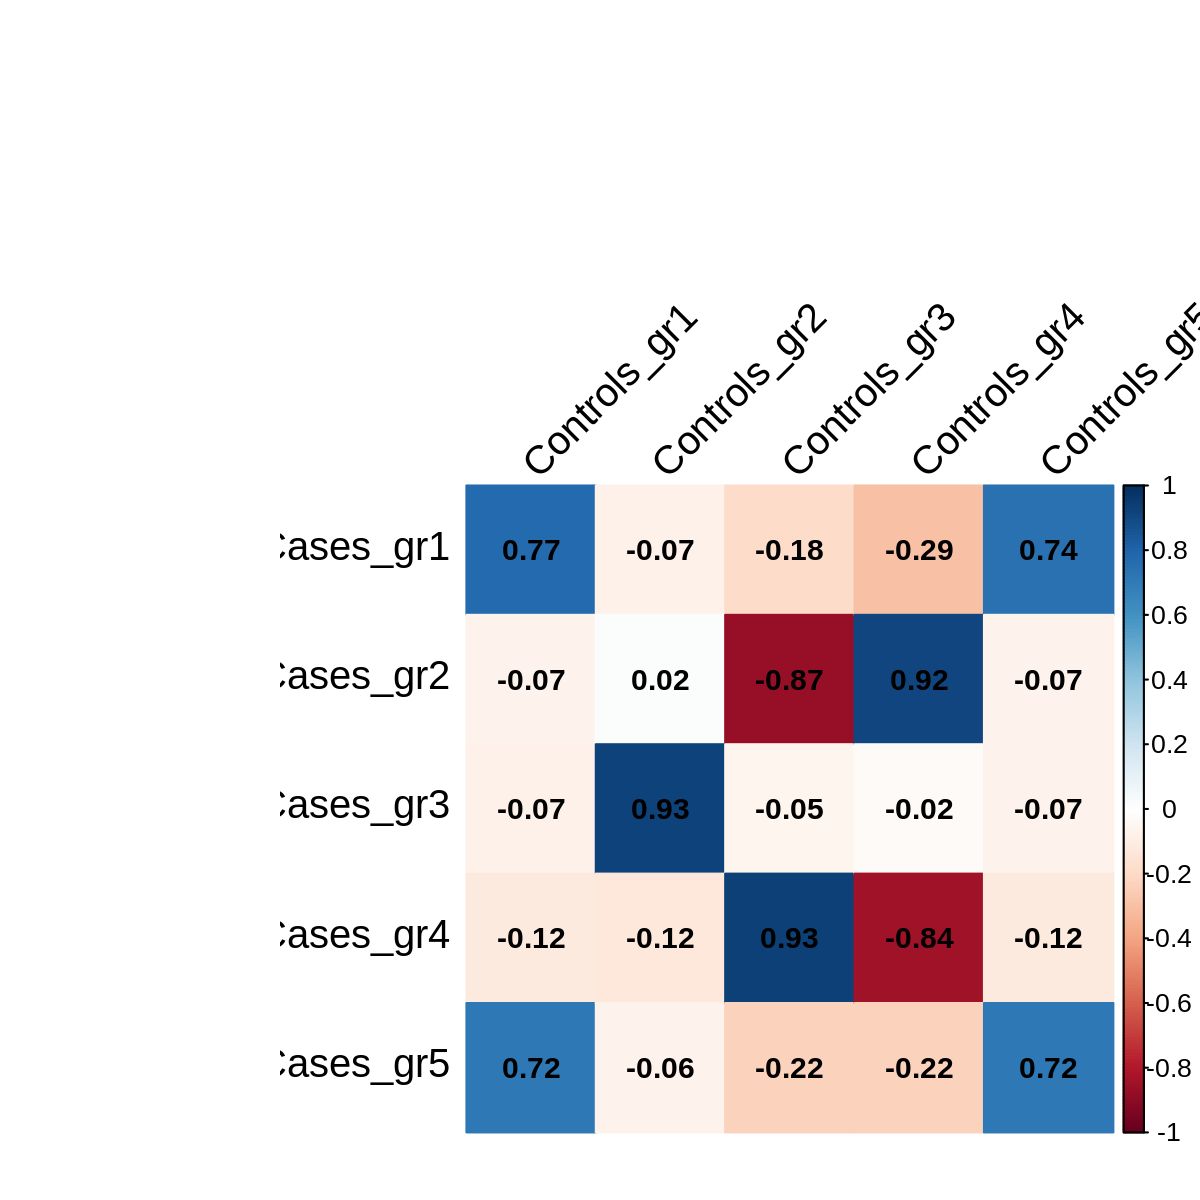

,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5
Cases_gr1,0.8294683,-0.499280764,-0.3185019,-0.4279636,0.8006615
Cases_gr2,-0.3481808,0.287691963,-0.5849430,0.8894620,-0.3093678
Cases_gr3,-0.4929365,0.611204249,0.1177653,0.2105020,-0.4754648
Cases_gr4,-0.3485376,-0.004601903,0.9021562,-0.5262824,-0.3680136
Cases_gr5,0.7791850,-0.457151785,-0.3461526,-0.3627837,0.7669097


[1] "N. common pheno for Cases_gr1 and Controls_gr1 = 204"
[1] "N. common pheno for Cases_gr1 and Controls_gr2 = 204"
[1] "N. common pheno for Cases_gr1 and Controls_gr3 = 204"
[1] "N. common pheno for Cases_gr1 and Controls_gr4 = 204"
[1] "N. common pheno for Cases_gr1 and Controls_gr5 = 203"
[1] "N. common pheno for Cases_gr2 and Controls_gr1 = 204"
[1] "N. common pheno for Cases_gr2 and Controls_gr2 = 204"
[1] "N. common pheno for Cases_gr2 and Controls_gr3 = 204"
[1] "N. common pheno for Cases_gr2 and Controls_gr4 = 204"
[1] "N. common pheno for Cases_gr2 and Controls_gr5 = 203"
[1] "N. common pheno for Cases_gr3 and Controls_gr1 = 204"
[1] "N. common pheno for Cases_gr3 and Controls_gr2 = 204"
[1] "N. common pheno for Cases_gr3 and Controls_gr3 = 204"
[1] "N. common pheno for Cases_gr3 and Controls_gr4 = 204"
[1] "N. common pheno for Cases_gr3 and Controls_gr5 = 203"
[1] "N. common pheno for Cases_gr4 and Controls_gr1 = 204"
[1] "N. common pheno for Cases_gr4 and Controls_gr2 = 20

Warning message in corrplot(cor_mat, sig.level = 0.05, p.mat = pval_mat, tl.col = "black", :
“col.lim interval too wide, please set a suitable value”
Warning message in corrplot(cor_mat, tl.col = "black", sig.level = 0.05, p.mat = pval_mat, :
“col.lim interval too wide, please set a suitable value”


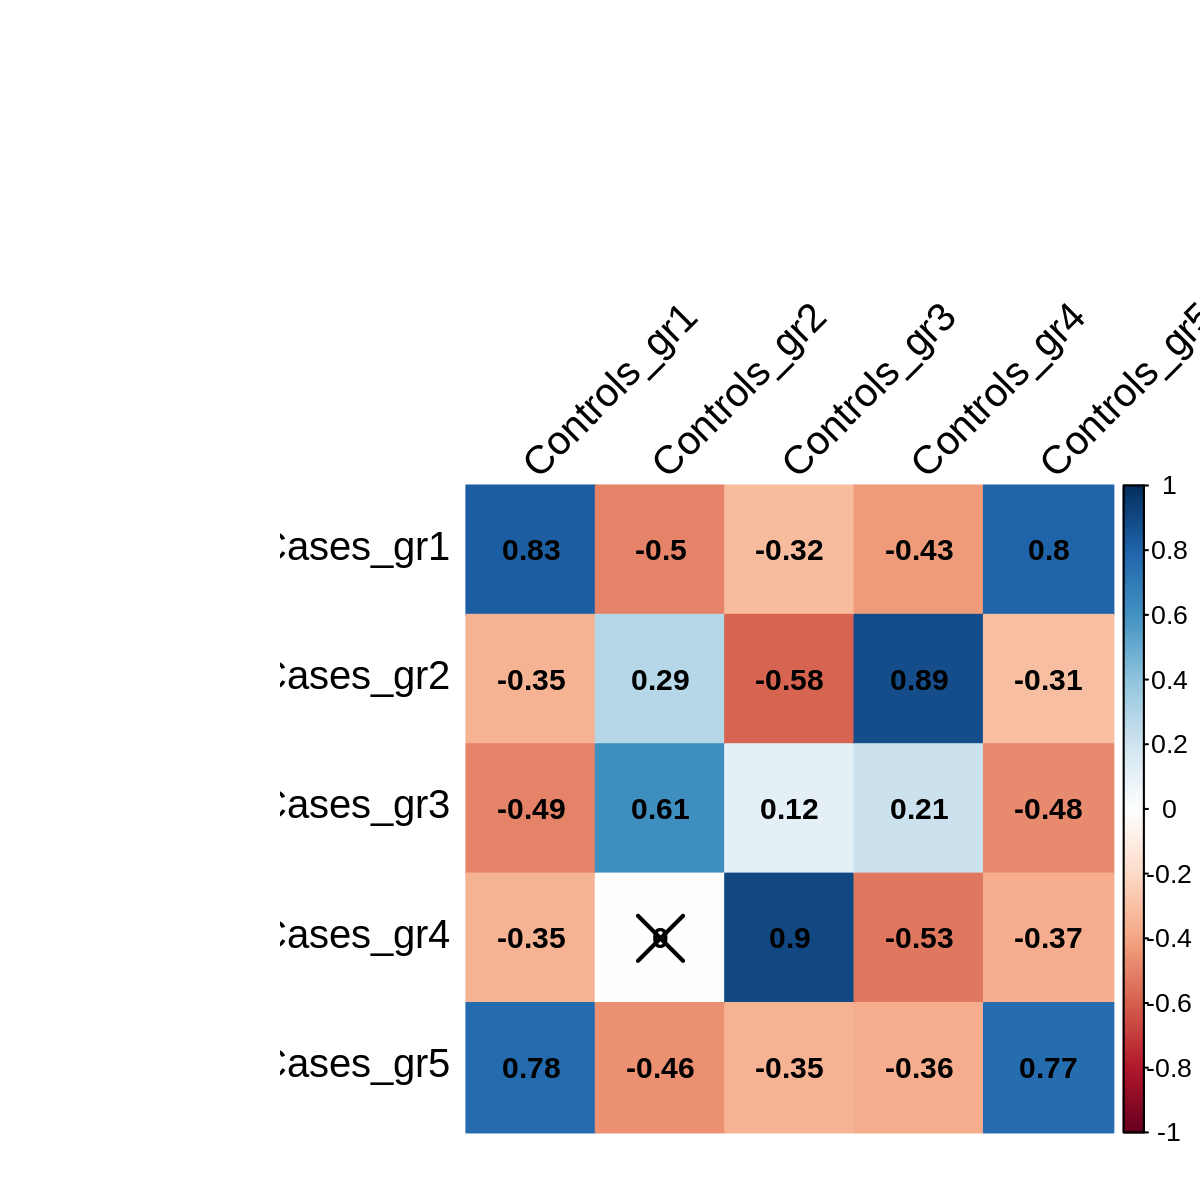

,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5
Cases_gr1,0.05453125,0.18557071,0.01511891,-0.11809129,0.03928384
Cases_gr2,0.13967131,0.08506758,-0.14143349,0.01081481,-0.14189489
Cases_gr3,-0.01261185,-0.27899188,-0.01802776,0.18252082,-0.11308196
Cases_gr4,-0.22729620,-0.10969477,0.21407909,-0.00705982,0.20635013
Cases_gr5,0.08518709,-0.26112433,-0.07964801,0.01128814,0.24671784


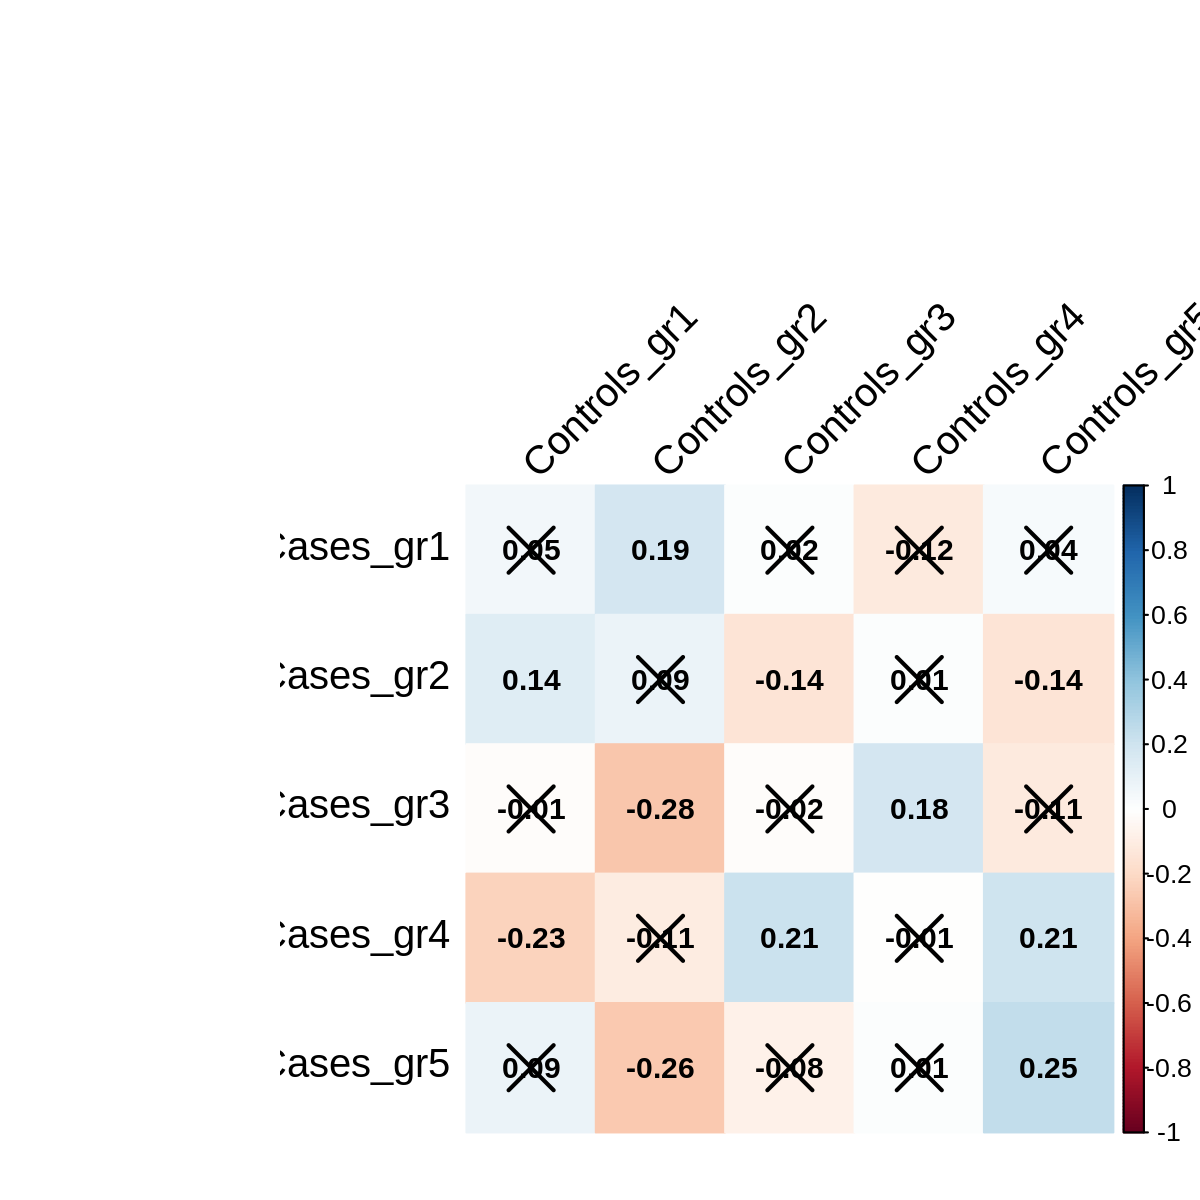

In [72]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 200)
plot_corr_feat(gene_cases, gene_controls, outFold, type_data = "Tscores", name_comp_controls = "Controls", width_pl = 6, height_pl = 6)
plot_corr_feat(path_cases, path_controls, outFold, type_data = "Pathscore", name_comp_controls = "Controls", width_pl = 6, height_pl = 6)
plot_corr_pheno(endop_cases, endop_controls, outFold, name_comp_controls = "Controls", width_pl = 6, height_pl = 6)

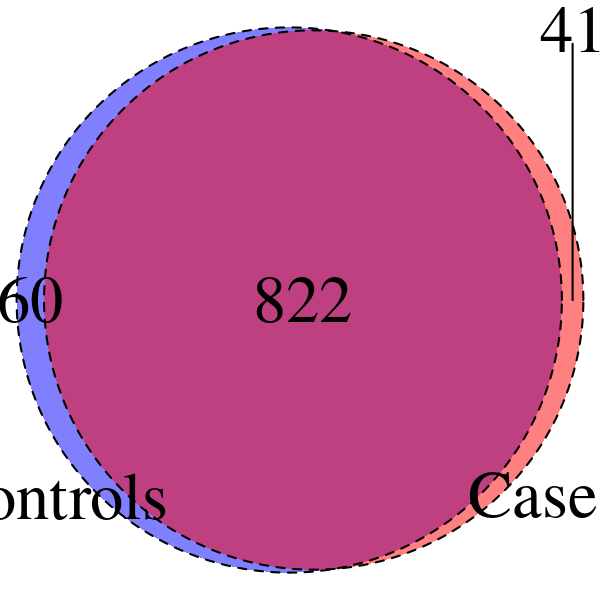

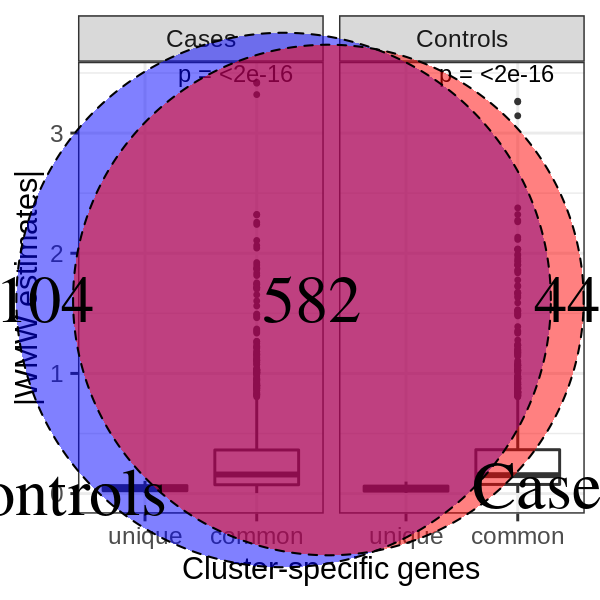

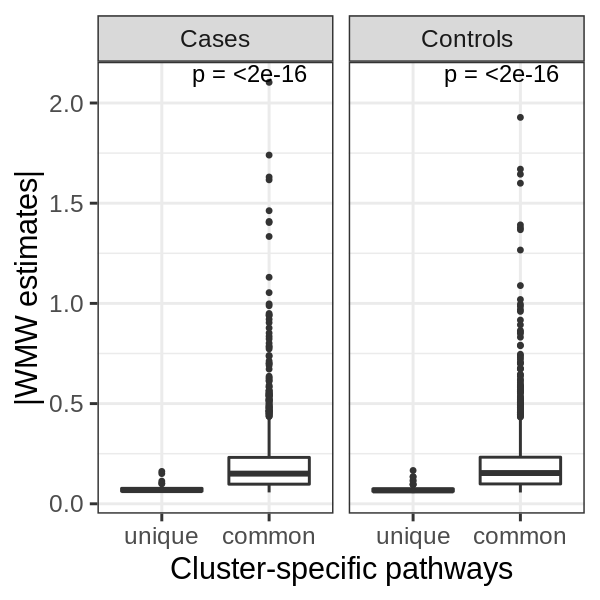

In [5]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 200)
plot_intersection(gene_cases, gene_controls, outFold, pval_corr_thr = 0.01, type_data = "Tscores", name_comp_controls = "Controls", width_pl = 3, height_pl = 3)
plot_intersection(path_cases, path_controls, outFold, pval_corr_thr = 0.01, type_data = "Pathscores", name_comp_controls = "Controls", width_pl = 3, height_pl = 3)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


[1] 0.4


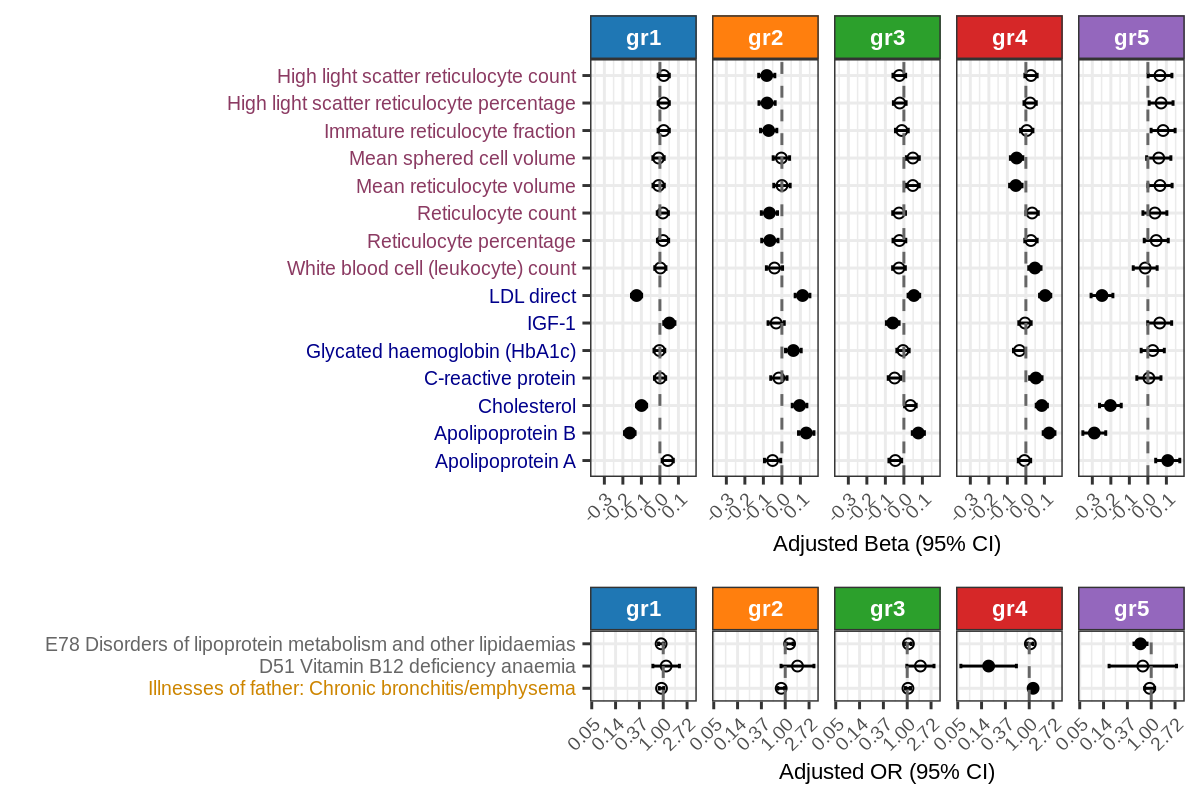

In [12]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 200)
endopheno_forest_plot(colorFile, endop_controls, pval_pheno = 0.0001, pval_corr_thr = 0.1, outFold, type_input = 'zscaled', type_cluster = 'Controls')


Family_history  ICD9-10_OPCS4 
             6             39 
# A tibble: 11 × 2
   Field                              meaning                                   
   <chr>                              <chr>                                     
 1 Apolipoprotein A                   NA                                        
 2 Apolipoprotein B                   NA                                        
 3 Cholesterol                        NA                                        
 4 LDL direct                         NA                                        
 5 IGF-1                              NA                                        
 6 White blood cell (leukocyte) count NA                                        
 7 Reticulocyte percentage            NA                                        
 8 Reticulocyte count                 NA                                        
 9 C-reactive protein                 NA                                        
10 Mean sphered cell volume

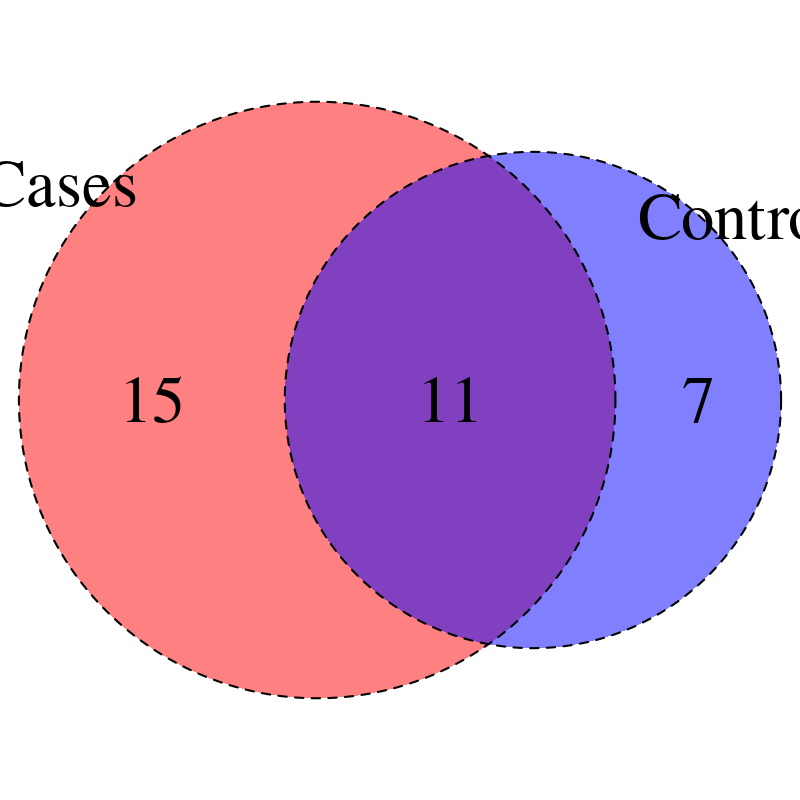

In [61]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200)
plot_intersection_endop(endop_cases, endop_controls, outFold, pval_corr_thr = 0.1, name_comp_controls = "Controls", width_pl = 4, height_pl = 4)

[1] 1
[1] "Apolipoprotein B" "Cholesterol"      "LDL direct"      
[1] 2
[1] "Apolipoprotein B"                   "Cholesterol"                       
[3] "LDL direct"                         "White blood cell (leukocyte) count"
[1] 3
[1] "Apolipoprotein B"        "Cholesterol"            
[3] "LDL direct"              "Reticulocyte percentage"
[5] "Reticulocyte count"     
[1] 4
[1] "Apolipoprotein B" "LDL direct"      
[1] 5
[1] "Apolipoprotein B"  "Cholesterol"       "LDL direct"       
[4] "Diagnoses - ICD10"


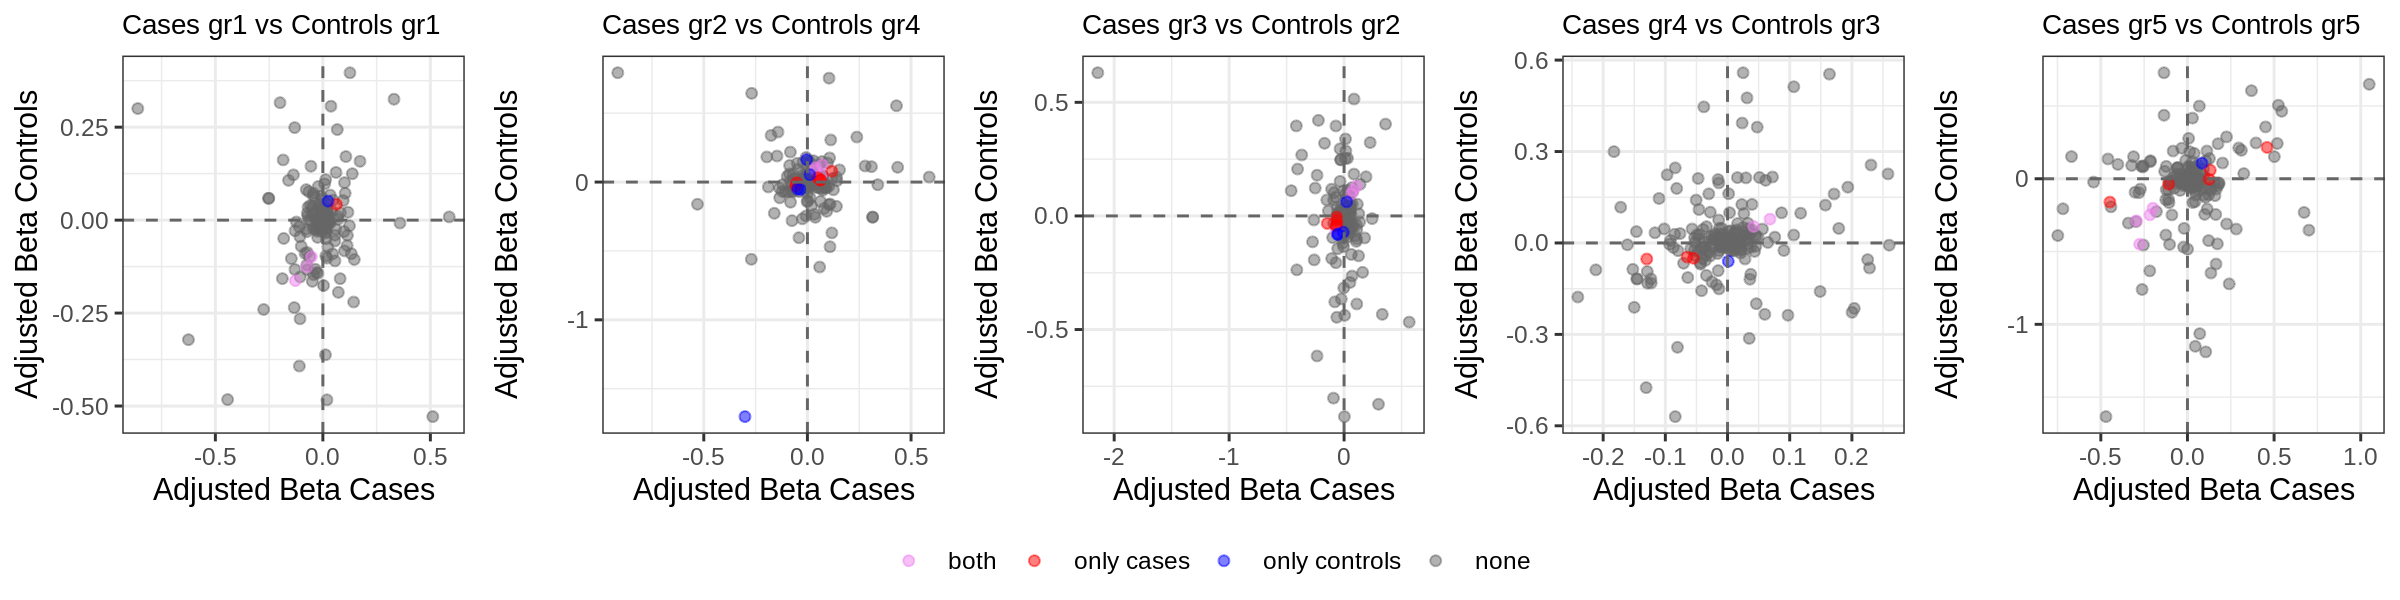

In [75]:
options(repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 200)
# df to pass from control to cases groups, manually created!
df_comparison <- data.frame(gr_cases = c(1,2,3,4,5), gr_controls = c(1,4,2,3,5))
plot_scatter_endopzstat(endop_cases, endop_controls, df_comparison, outFold)

In [70]:
sort(unique(endop_cases$se_beta), decreasing = T)

[1] 1.383656e+03 6.264806e+02 6.225324e+02 1.167253e+00 1.010576e+00
   [6] 1.010406e+00 1.008424e+00 1.007469e+00 8.929940e-01 8.736119e-01
  [11] 8.266298e-01 7.740952e-01 7.524983e-01 7.204756e-01 7.190338e-01
  [16] 7.185334e-01 7.166456e-01 7.147202e-01 6.022324e-01 5.955515e-01
  [21] 5.947937e-01 5.935016e-01 5.916070e-01 5.914000e-01 5.893139e-01
  [26] 5.891137e-01 5.884938e-01 5.881628e-01 5.878145e-01 5.860853e-01
  [31] 5.847351e-01 5.721227e-01 5.417378e-01 5.206321e-01 5.197506e-01
  [36] 5.152362e-01 5.118025e-01 5.113918e-01 5.112858e-01 5.079365e-01
  [41] 5.051609e-01 4.812686e-01 4.708107e-01 4.700817e-01 4.649194e-01
  [46] 4.607314e-01 4.341031e-01 4.327420e-01 4.305715e-01 4.285542e-01
  [51] 4.273855e-01 4.269317e-01 4.199466e-01 4.182246e-01 4.174015e-01
  [56] 4.166153e-01 4.103166e-01 4.056442e-01 4.049847e-01 4.035944e-01
  [61] 4.025486e-01 4.012941e-01 3.990019e-01 3.982882e-01 3.978450e-01
  [66] 3.961637e-01 3.954984e-01 3.938889e-01 3.912584e-01 3.894627e-01
  [71] 3.877377e-01 3.869286e-01 3.846426e-01 3.837178e-01 3.821747e-01
  [76] 3.793987e-01 3.757173e-01 3.691184e-01 3.667699e-01 3.616227e-01
  [81] 3.609277e-01 3.593728e-01 3.580558e-01 3.562853e-01 3.555812e-01
  [86] 3.533916e-01 3.501113e-01 3.497315e-01 3.495282e-01 3.474188e-01
  [91] 3.472698e-01 3.464334e-01 3.462275e-01 3.392315e-01 3.363343e-01
  [96] 3.283134e-01 3.280418e-01 3.279029e-01 3.270600e-01 3.262571e-01
 [101] 3.261836e-01 3.238782e-01 3.234433e-01 3.229223e-01 3.200655e-01
 [106] 3.200485e-01 3.189283e-01 3.173307e-01 3.172527e-01 3.145464e-01
 [111] 3.137627e-01 3.113316e-01 3.098331e-01 3.091333e-01 3.084618e-01
 [116] 3.083522e-01 3.081113e-01 3.071117e-01 3.056379e-01 3.056229e-01
 [121] 3.049001e-01 3.040046e-01 3.024011e-01 2.999458e-01 2.998744e-01
 [126] 2.997112e-01 2.995128e-01 2.987297e-01 2.981115e-01 2.979115e-01
 [131] 2.967046e-01 2.961399e-01 2.928008e-01 2.925351e-01 2.919726e-01
 [136] 2.919232e-01 2.912007e-01 2.905945e-01 2.900165e-01 2.892362e-01
 [141] 2.880734e-01 2.869133e-01 2.868864e-01 2.858022e-01 2.856751e-01
 [146] 2.852300e-01 2.848374e-01 2.847312e-01 2.837429e-01 2.830740e-01
 [151] 2.829095e-01 2.828965e-01 2.813213e-01 2.802832e-01 2.797961e-01
 [156] 2.795123e-01 2.775029e-01 2.766383e-01 2.755125e-01 2.752775e-01
 [161] 2.750455e-01 2.747986e-01 2.745909e-01 2.734042e-01 2.718656e-01
 [166] 2.717237e-01 2.715159e-01 2.700489e-01 2.694534e-01 2.676962e-01
 [171] 2.670277e-01 2.664037e-01 2.651894e-01 2.649278e-01 2.642365e-01
 [176] 2.641876e-01 2.616420e-01 2.605614e-01 2.604777e-01 2.587753e-01
 [181] 2.586571e-01 2.584294e-01 2.584103e-01 2.582538e-01 2.560375e-01
 [186] 2.550933e-01 2.539199e-01 2.517690e-01 2.510487e-01 2.504155e-01
 [191] 2.499157e-01 2.491563e-01 2.482937e-01 2.480659e-01 2.472727e-01
 [196] 2.468026e-01 2.462816e-01 2.432304e-01 2.432129e-01 2.429590e-01
 [201] 2.388451e-01 2.388003e-01 2.387828e-01 2.386963e-01 2.383896e-01
 [206] 2.380867e-01 2.376525e-01 2.375115e-01 2.369376e-01 2.356594e-01
 [211] 2.345044e-01 2.344744e-01 2.344655e-01 2.341478e-01 2.337311e-01
 [216] 2.331182e-01 2.326055e-01 2.323290e-01 2.322720e-01 2.308511e-01
 [221] 2.306866e-01 2.305672e-01 2.303348e-01 2.288553e-01 2.284034e-01
 [226] 2.281805e-01 2.274139e-01 2.260487e-01 2.257835e-01 2.254160e-01
 [231] 2.243495e-01 2.230260e-01 2.201187e-01 2.163233e-01 2.150345e-01
 [236] 2.142817e-01 2.127383e-01 2.125317e-01 2.118756e-01 2.114805e-01
 [241] 2.110043e-01 2.102699e-01 2.102216e-01 2.102153e-01 2.096915e-01
 [246] 2.085587e-01 2.084746e-01 2.084383e-01 2.081102e-01 2.064150e-01
 [251] 2.063093e-01 2.051322e-01 2.049478e-01 2.045175e-01 2.032482e-01
 [256] 2.031522e-01 2.025163e-01 2.007546e-01 2.006606e-01 2.002058e-01
 [261] 1.992242e-01 1.979672e-01 1.978911e-01 1.975570e-01 1.974376e-01
 [266] 1.961775e-01 1.960610e-01 1.933957e-01 1.933913e-01 1.929695e-01
 [271] 1.915173e-01 1.907090e-01 1.901414e-01 1.892154e-01 1.892109e-01
 [276] 1.889022e-01 1.883872e-01 1.869481e-

### Conclusions on cases vs controls comparison:
- the number of groups is the same, with a similar fraction of cases distribution and cluster quality
- Indeed, when looking at association of genes with clusters, there are some groups in cases that are more correlated with other in controls, also true for pathways but to a lesser extent.
- We can then assume that cas 1 --> con 1, cas 2 --> con 4, cas 3 --> con 2, cas 4 --> con 3, cas 5 --> con 5
- When looking at cluster-specific genes and pathways, mostly are shared among cases and controls. Those not in common do not have the strongest effect size on the partition.
- as regards endophenotypes, only 18 are in the controls compared to 26 of which 11 are in common with cases (LDL related + IGF1, C-reactive, retyc, white blood), the overall endophenotype trend among group is not present anymore!

We can conclude that the clustering is similar in terms of drivers, but the consequents at the level of endophenotypes are different! Hence the clustering charachteristic is true only in the context of the disease

type,n_samples,gr
<chr>,<int>,<fct>
Cases,6105,gr1
Cases,4783,gr2
Cases,2831,gr3
Cases,4520,gr4
Cases,784,gr5
Controls,158,gr1
Controls,399,gr2
Controls,270,gr3
Controls,4652,gr4


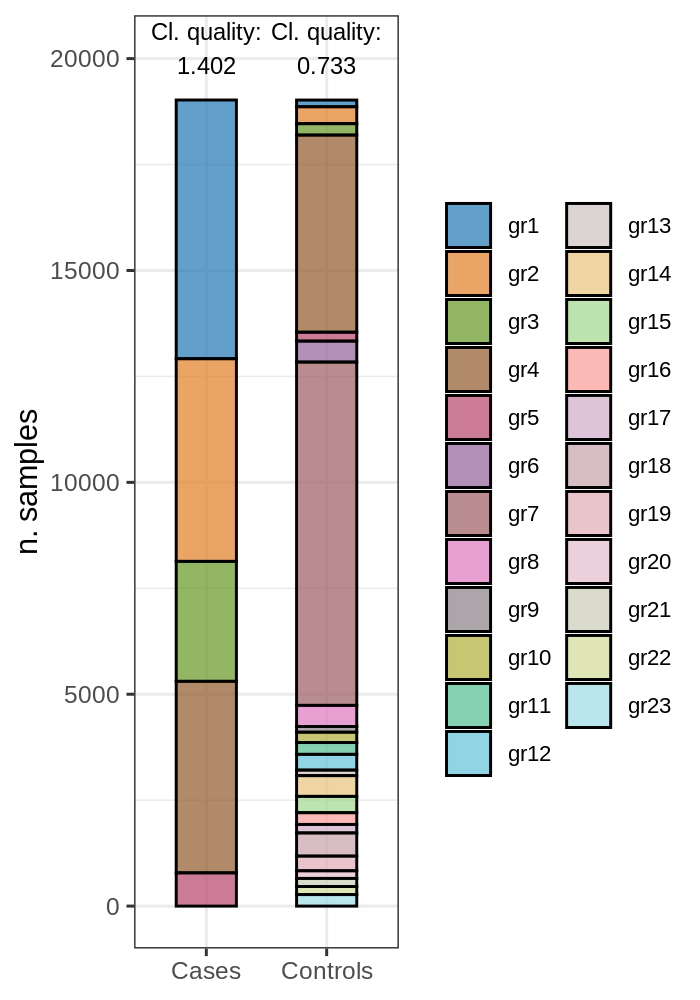

In [14]:
options(repr.plot.width = 3.5, repr.plot.height = 5, repr.plot.res = 200)
plot_stat_cases_controls(out_cases, out_controls_original, outFold, name_comp_controls = "ControlsOriginal", width_pl = 3.5, height_pl = 5)

,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5,Controls_gr6,Controls_gr7,Controls_gr8,Controls_gr9,Controls_gr10,⋯,Controls_gr14,Controls_gr15,Controls_gr16,Controls_gr17,Controls_gr18,Controls_gr19,Controls_gr20,Controls_gr21,Controls_gr22,Controls_gr23
Cases_gr1,-0.003443986,0.005997353,-0.0003896975,0.045466914,0.044797417,-0.033930512,-0.04413130,-0.027511791,-0.013340144,-0.033671480,⋯,-0.002201208,-0.01581445,-0.017309423,-0.0000776269,-0.03689078,-0.02059833,-0.020439252,0.000391364,-0.02180506,-0.0047174178
Cases_gr2,0.034541830,-0.102673559,0.3136986320,-0.533766378,-0.162781143,0.172495511,0.61354312,0.087674995,-0.147794788,0.226626096,⋯,0.259974685,-0.34223936,0.288458132,-0.0025577894,0.41201391,0.29437420,-0.016853940,0.092514690,0.06373547,0.2882394948
Cases_gr3,-0.008667328,-0.016163248,-0.0032065727,0.012652379,0.007073922,-0.003089862,-0.01423367,-0.013755064,-0.030636334,-0.004706460,⋯,-0.004713591,-0.01558583,0.023390827,0.0210858107,0.01349183,0.01163023,-0.022106900,-0.014232347,0.02404250,-0.0064468573
Cases_gr4,-0.023618677,0.119778364,-0.3094829050,0.491866609,0.129129082,-0.144367247,-0.56447862,-0.058941447,0.186065912,-0.203049374,⋯,-0.251791075,0.36252650,-0.287923879,-0.0205194800,-0.39205831,-0.28624765,0.049434934,-0.079011963,-0.07067780,-0.2765815687
Cases_gr5,-0.014039886,-0.015525347,0.0246485321,-0.008256016,-0.006897344,-0.010695039,0.01318810,-0.003738783,-0.007762754,0.002008797,⋯,0.029119721,-0.01117858,-0.006104034,0.0070849182,0.01161138,0.00480634,0.009929128,-0.009153769,-0.02201756,-0.0003526896


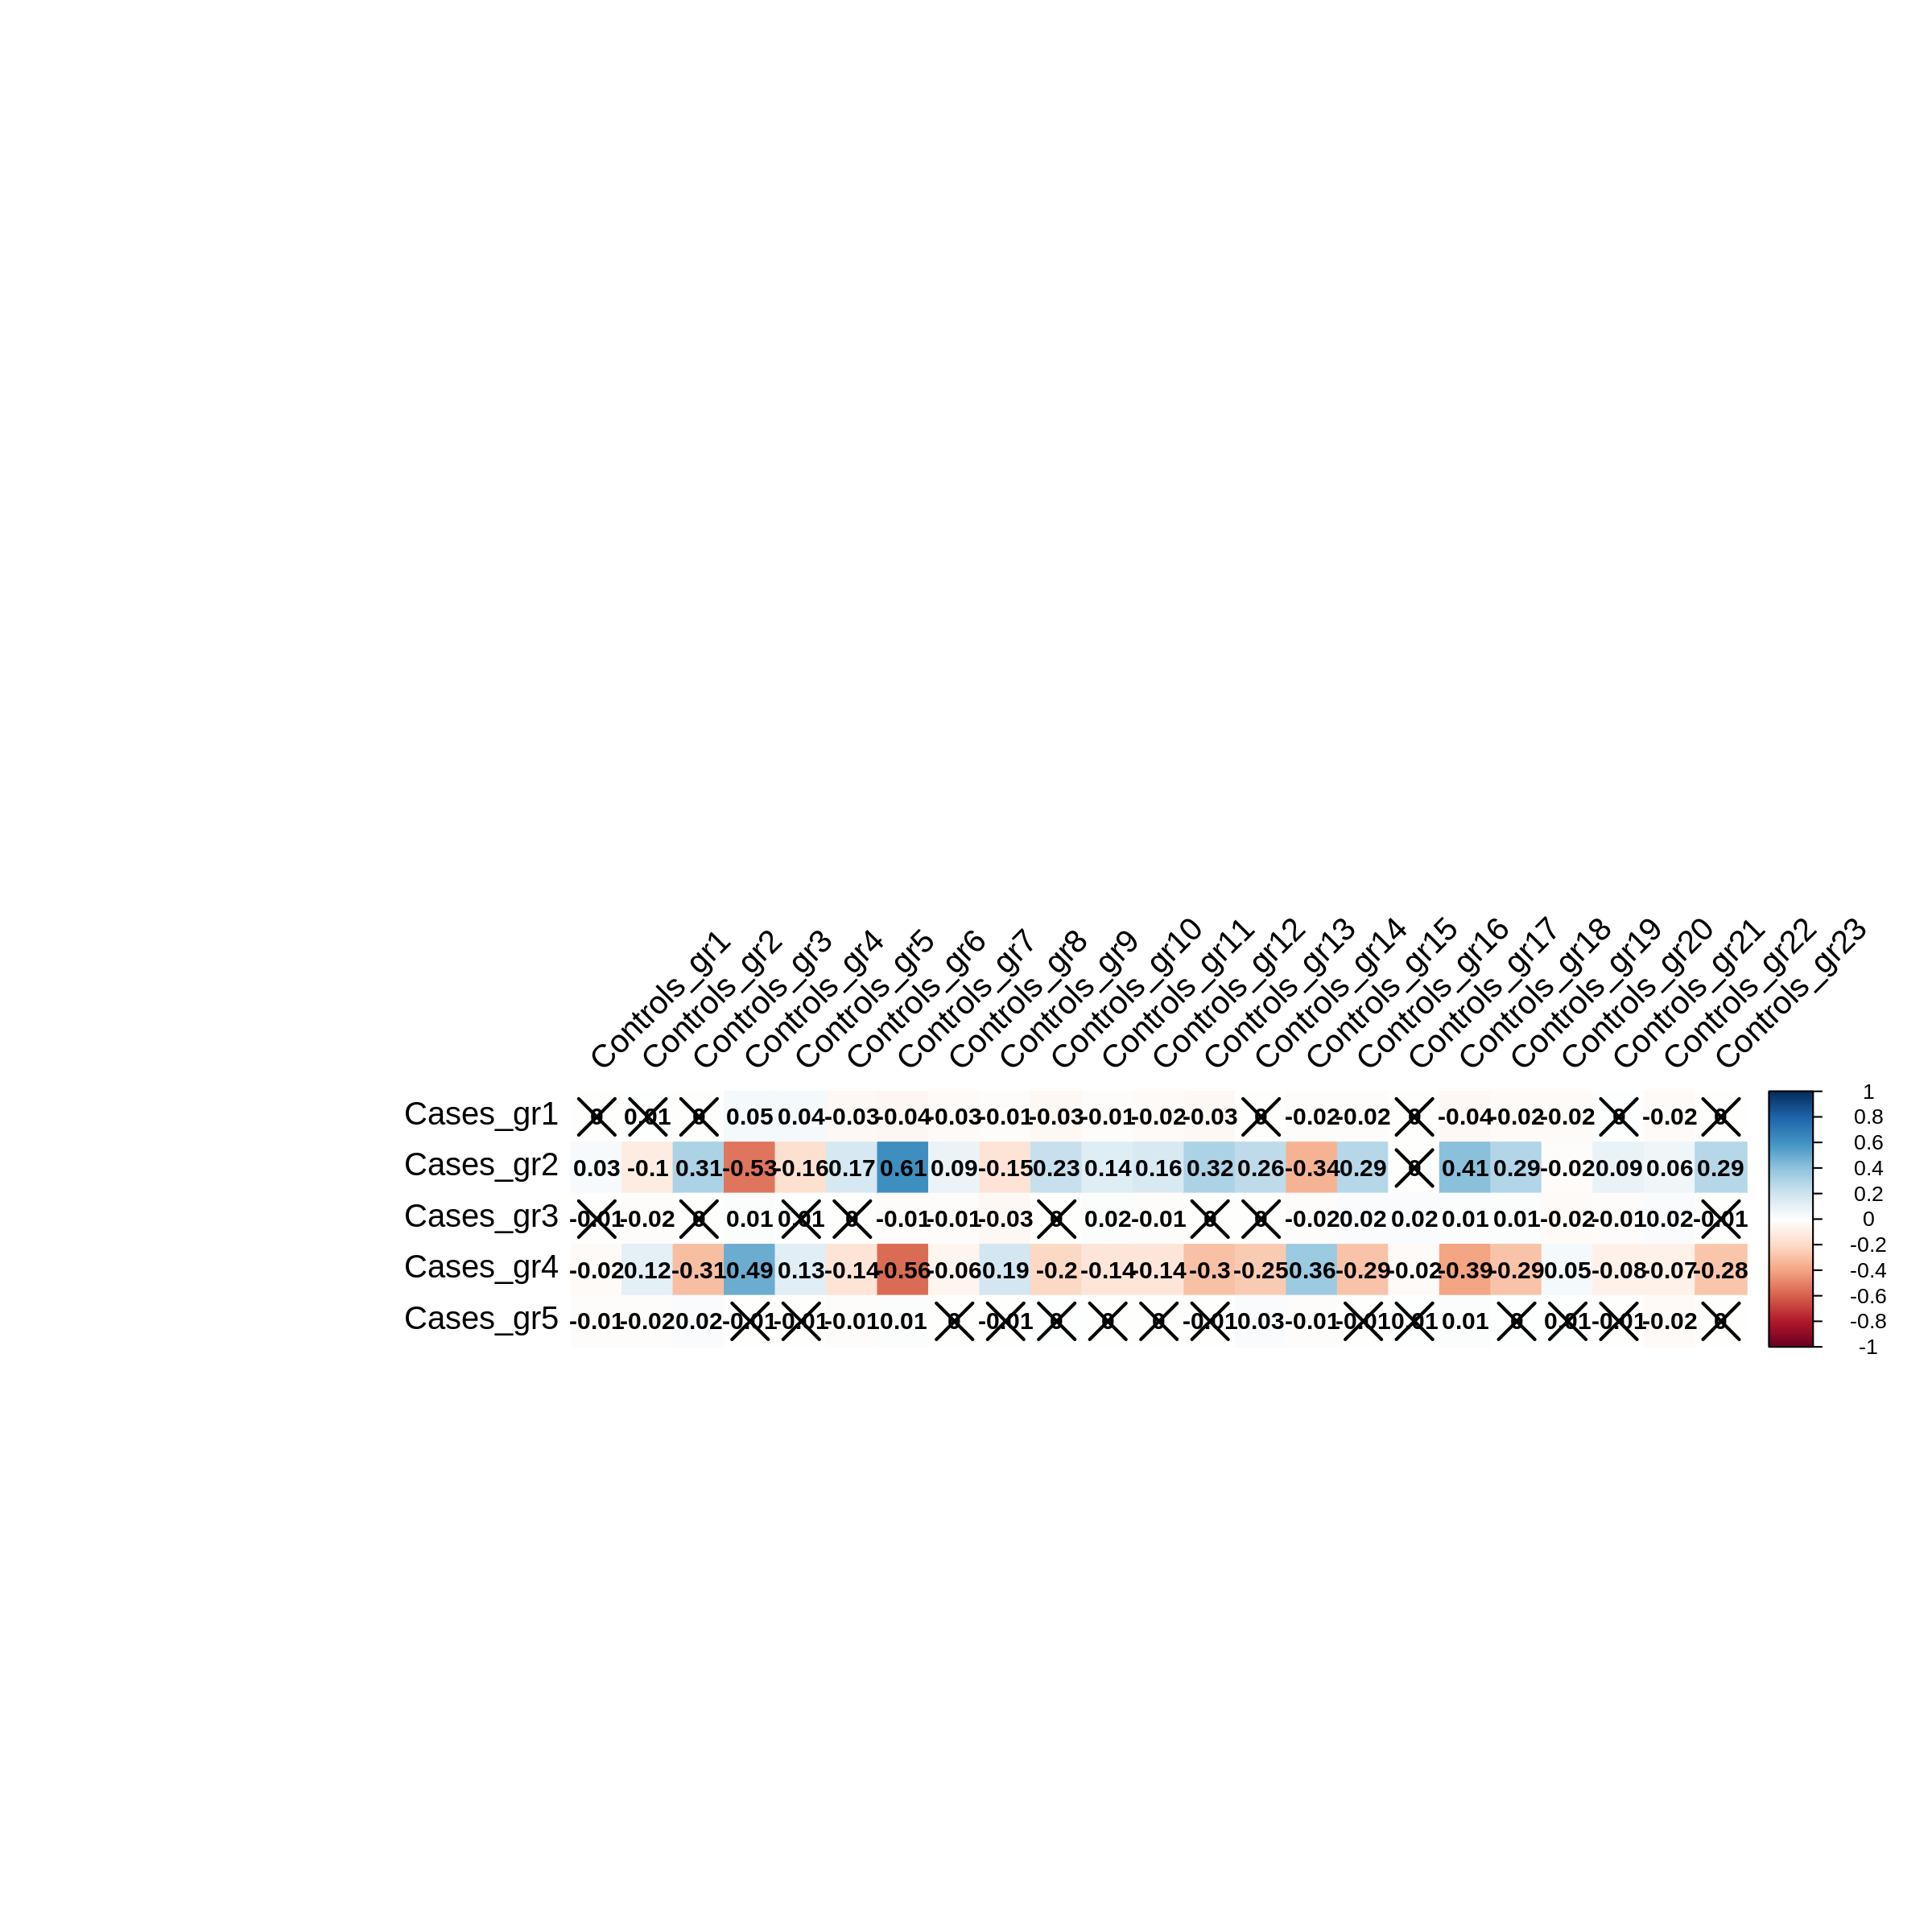

,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5,Controls_gr6,Controls_gr7,Controls_gr8,Controls_gr9,Controls_gr10,⋯,Controls_gr14,Controls_gr15,Controls_gr16,Controls_gr17,Controls_gr18,Controls_gr19,Controls_gr20,Controls_gr21,Controls_gr22,Controls_gr23
Cases_gr1,-0.023510959,0.01796328,0.05262036,0.05046840,0.031281809,-0.05754016,-0.03250264,-0.037567133,-0.02691459,-0.04342160,⋯,0.01954994,-0.036649171,-0.03190276,0.028184443,-0.05780096,-0.02744259,-0.01122951,0.023486444,-0.03554491,-0.021317976
Cases_gr2,0.012259381,-0.05573405,0.22589195,-0.55752187,-0.178470323,0.15819115,0.54223261,0.095253962,-0.03945276,0.18981942,⋯,0.18762526,-0.192046311,0.23072468,-0.048952849,0.32733645,0.19525791,-0.03734551,0.084424424,0.04662239,0.213495123
Cases_gr3,-0.005130489,-0.06329368,-0.02575761,0.06175865,0.007345744,-0.02305641,-0.07068480,0.001336382,-0.05413197,-0.00508712,⋯,-0.04699553,-0.001553264,0.05383069,0.028216461,0.03681095,0.03713542,-0.05352166,-0.031855301,0.06594581,-0.033428170
Cases_gr4,0.009167173,0.07660398,-0.27266223,0.48827342,0.143458882,-0.08989495,-0.48904740,-0.057475673,0.08625571,-0.13274889,⋯,-0.19547717,0.238182574,-0.22055915,0.007742262,-0.28425635,-0.19185024,0.07070561,-0.088911445,-0.03910695,-0.176422976
Cases_gr5,0.004874363,-0.02290762,0.05375343,-0.01692965,0.012639311,-0.02601836,0.03495009,-0.015413292,0.01328642,-0.05543284,⋯,0.04780643,-0.038743757,-0.02497124,0.001113652,-0.03240080,0.01009609,0.00857428,-0.002999581,-0.03256694,-0.007756068


[1] "N. common pheno for Cases_gr1 and Controls_gr1 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr2 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr3 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr4 = 204"
[1] "N. common pheno for Cases_gr1 and Controls_gr5 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr6 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr7 = 204"
[1] "N. common pheno for Cases_gr1 and Controls_gr8 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr9 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr10 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr11 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr12 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr13 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr14 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr15 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_gr16 = 202"
[1] "N. common pheno for Cases_gr1 and Controls_g

Warning message in corrplot(cor_mat, sig.level = 0.05, p.mat = pval_mat, tl.col = "black", :
“col.lim interval too wide, please set a suitable value”
Warning message in corrplot(cor_mat, tl.col = "black", sig.level = 0.05, p.mat = pval_mat, :
“col.lim interval too wide, please set a suitable value”


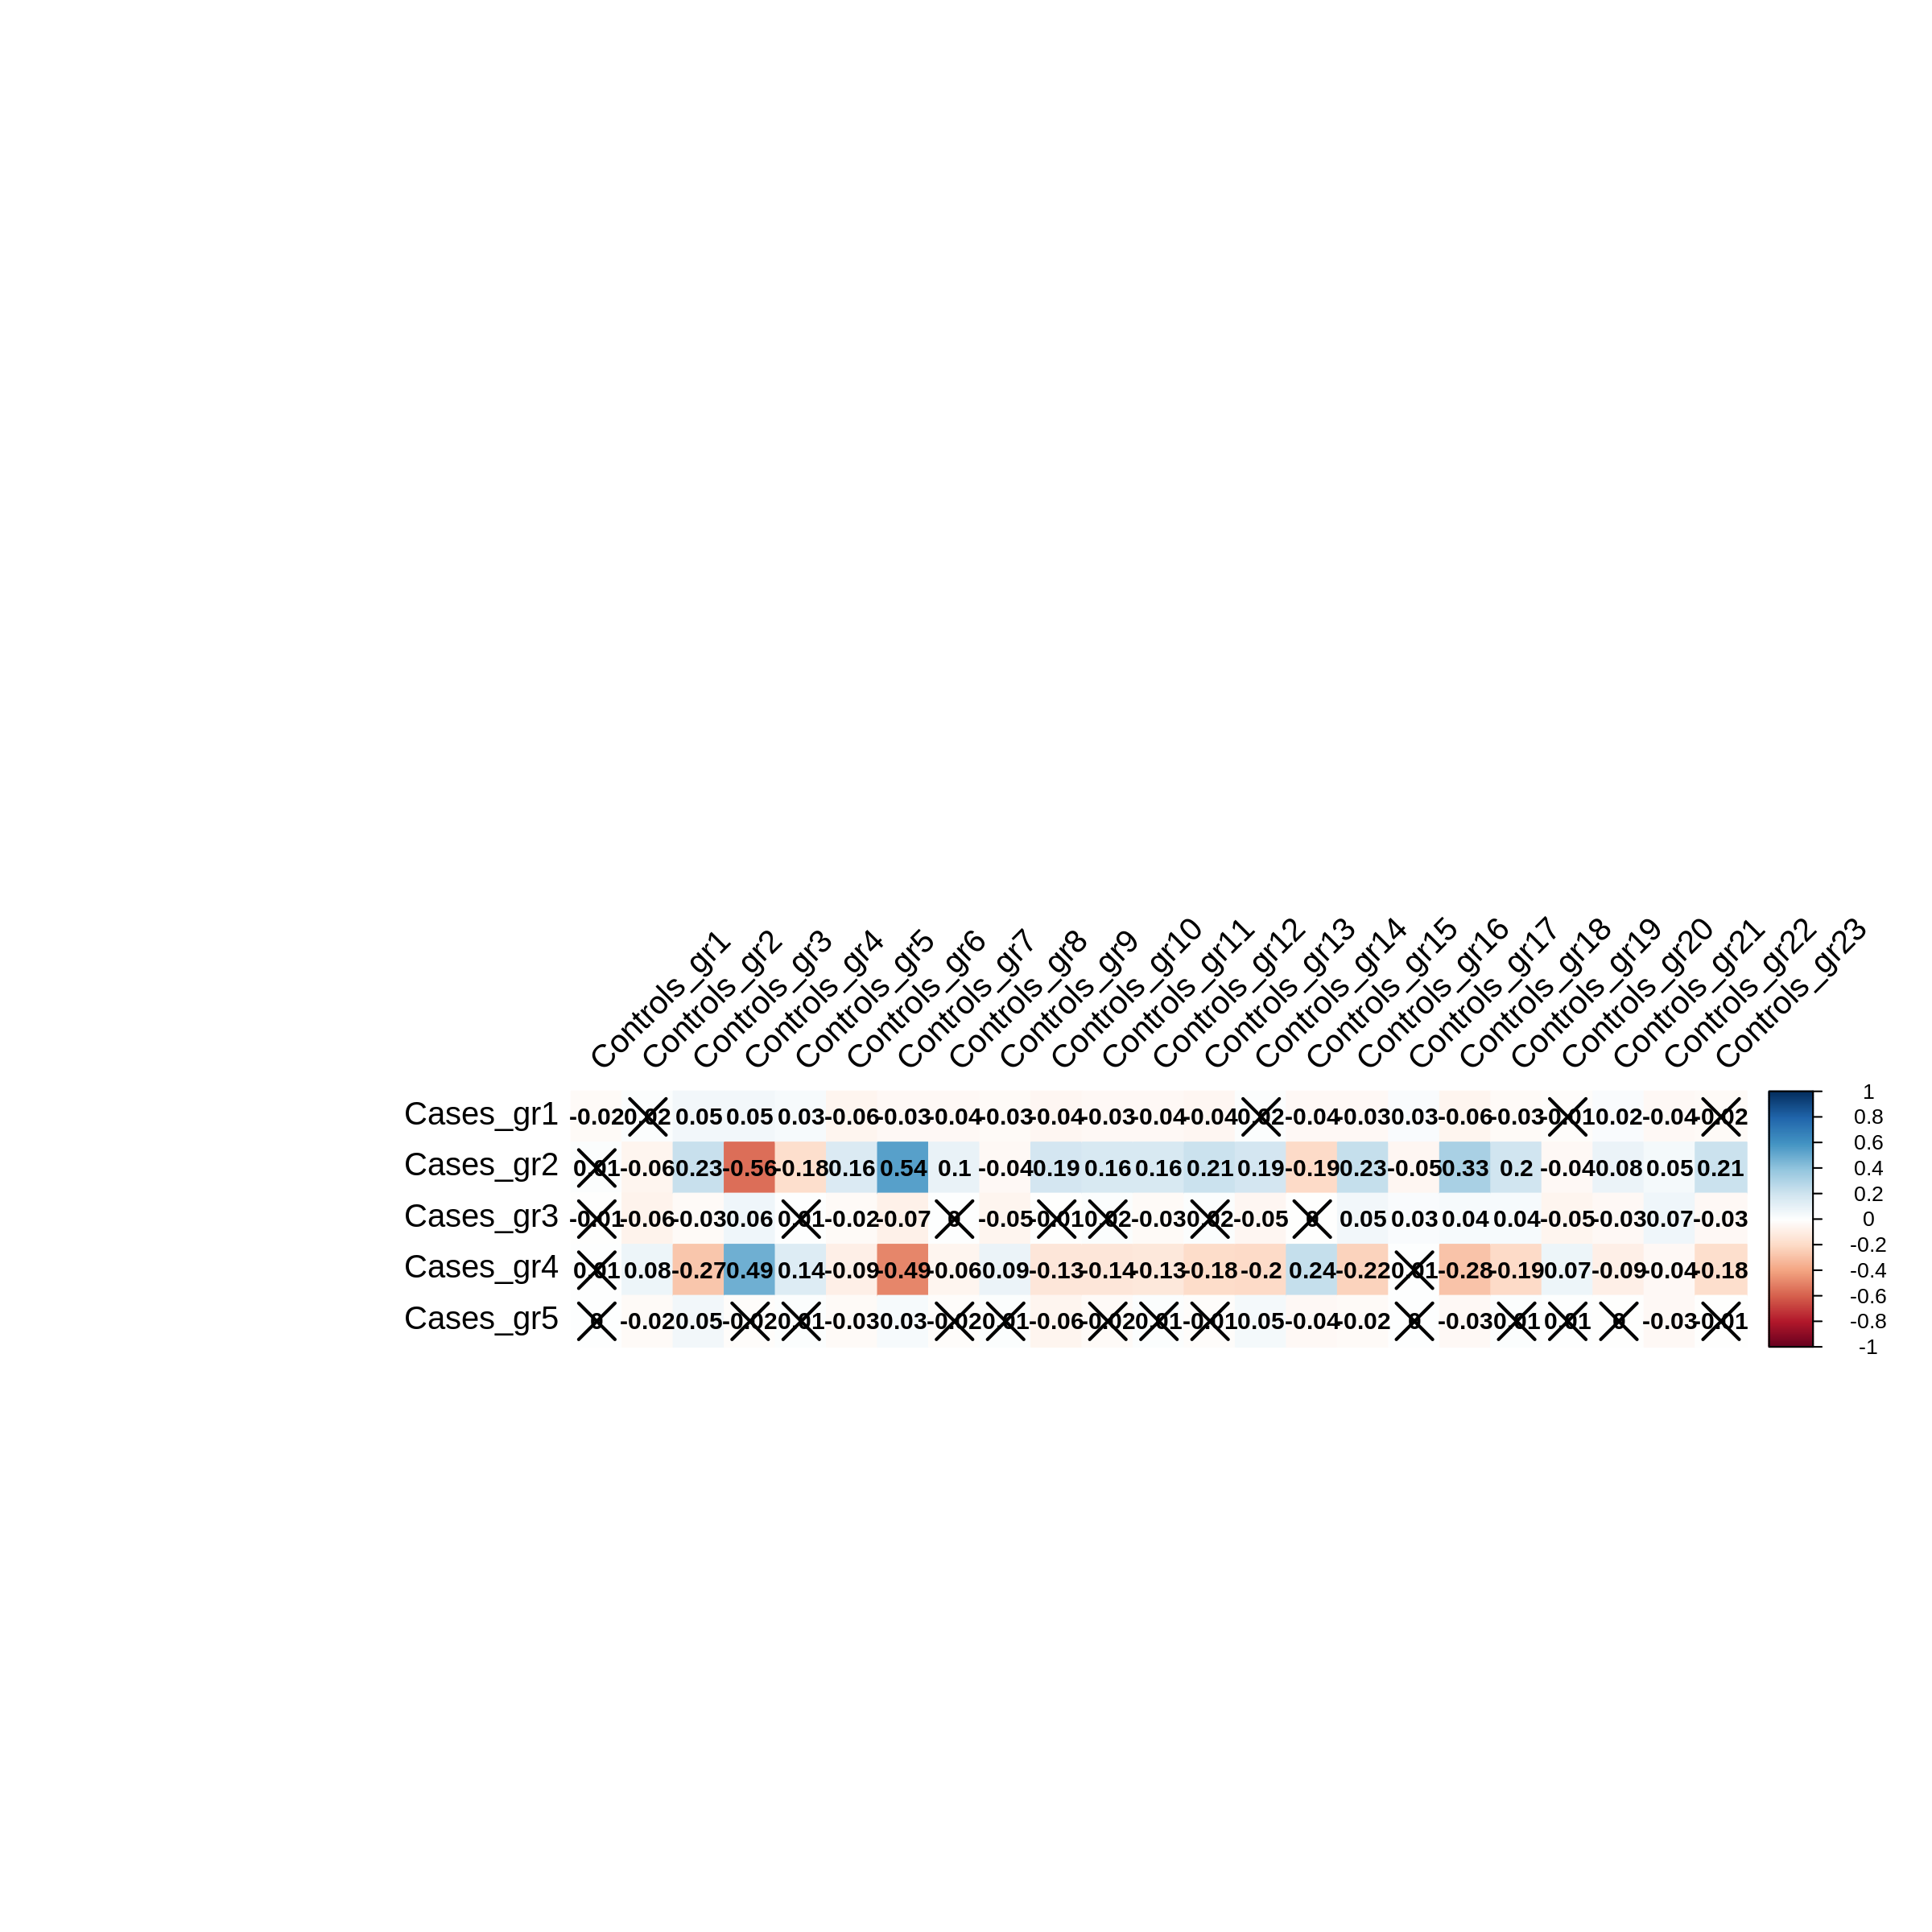

,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5,Controls_gr6,Controls_gr7,Controls_gr8,Controls_gr9,Controls_gr10,⋯,Controls_gr14,Controls_gr15,Controls_gr16,Controls_gr17,Controls_gr18,Controls_gr19,Controls_gr20,Controls_gr21,Controls_gr22,Controls_gr23
Cases_gr1,0.52346709,-0.020067537,0.28515211,-0.12942455,0.15700691,-0.0009678551,0.04038822,0.20059597,0.18857655,0.18030737,⋯,-0.01179291,0.30162738,0.12488283,0.17563995,0.26989601,0.16323670,0.28678878,0.1559199,0.10570161,0.165130600
Cases_gr2,-0.42184457,-0.038418944,-0.08301759,-0.01126075,-0.11650271,-0.0433638336,0.01229395,-0.20805298,-0.07189886,-0.04511155,⋯,-0.10779415,-0.28564013,0.04991054,0.01558403,-0.02562834,0.01118532,-0.22045433,0.1162116,0.02865050,0.041745997
Cases_gr3,-0.14000468,-0.027118904,-0.01840875,0.20280472,0.04295982,0.0967241501,0.07149539,0.08432495,0.03119686,-0.10016496,⋯,0.15341648,-0.14190709,-0.22033353,-0.08477783,-0.02759628,-0.10578160,-0.25826444,-0.0760635,-0.03453358,-0.141989527
Cases_gr4,-0.02315634,0.166707006,-0.21565403,0.03495630,0.05545019,0.0383292195,-0.10319211,0.02990942,-0.18294864,-0.08102961,⋯,0.05241220,-0.05092549,0.18806091,-0.17490190,-0.18224526,-0.11930295,0.03631637,-0.1717613,-0.07627682,-0.117226528
Cases_gr5,0.20587146,-0.005836403,-0.02293863,-0.09557285,-0.03781376,0.0025253889,0.13857529,0.02934818,0.26137981,0.01743529,⋯,-0.03801329,0.38297544,-0.26377316,-0.02278113,-0.04898234,0.01890662,0.28082465,-0.2722447,0.01159638,0.002959354


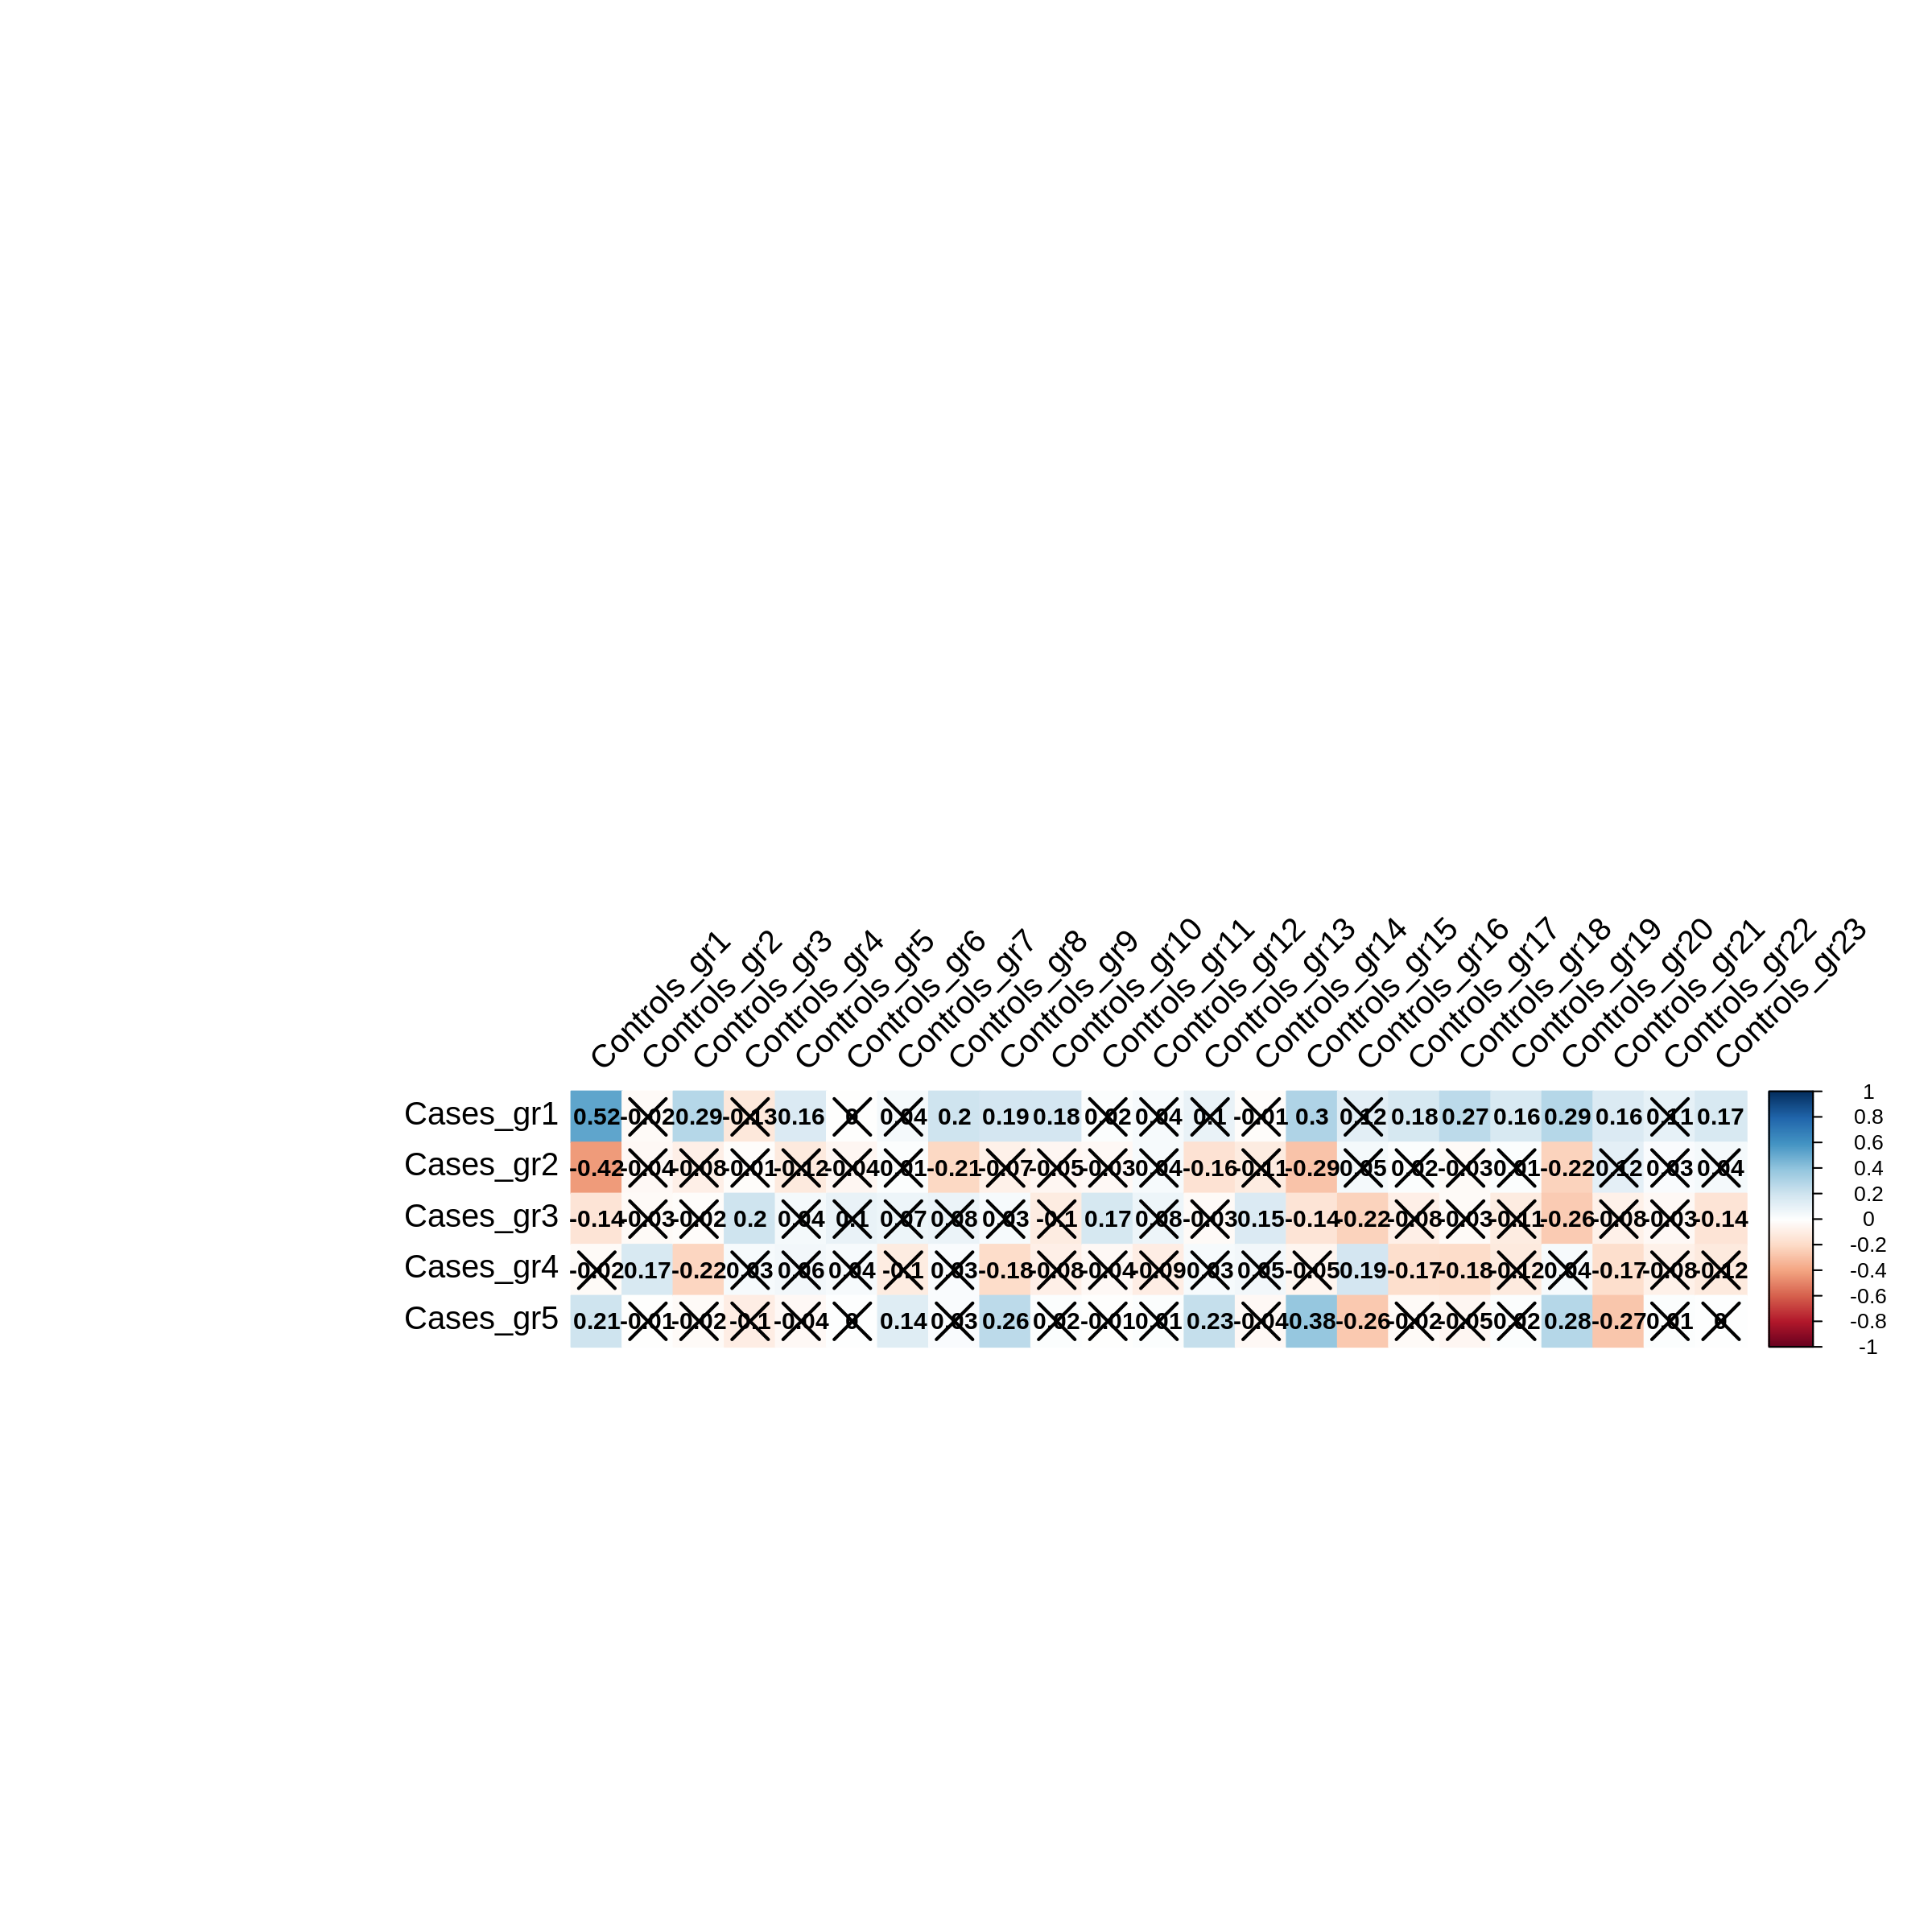

In [7]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 200)
plot_corr_feat(gene_cases, gene_controls_original, outFold, type_data = "Tscores", name_comp_controls = "ControlsOriginal", width_pl = 12, height_pl = 12)
plot_corr_feat(path_cases, path_controls_original, outFold, type_data = "Pathscores", name_comp_controls = "ControlsOriginal", width_pl = 12, height_pl = 12)
plot_corr_pheno(endop_cases, endop_controls_original, outFold, name_comp_controls = "ControlsOriginal", width_pl = 12, height_pl = 12)

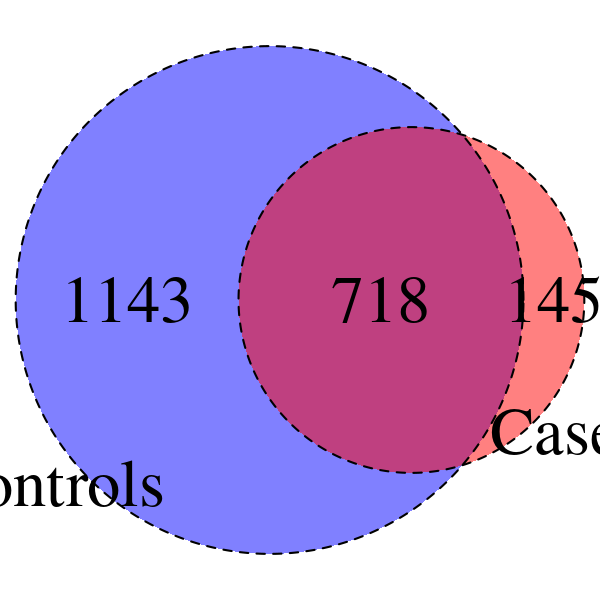

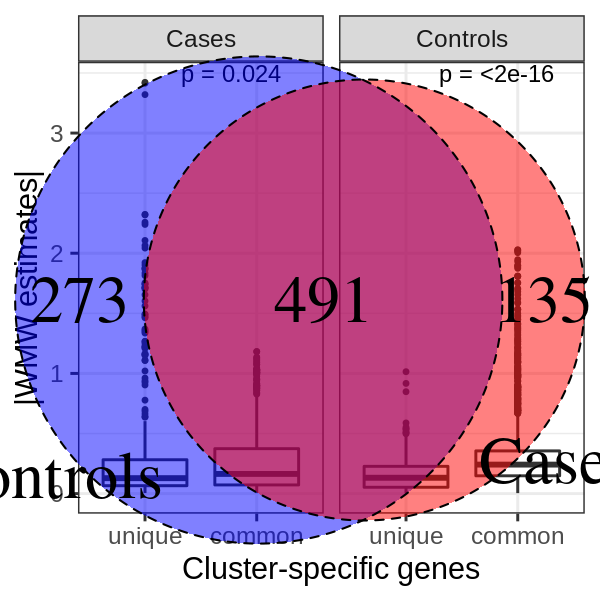

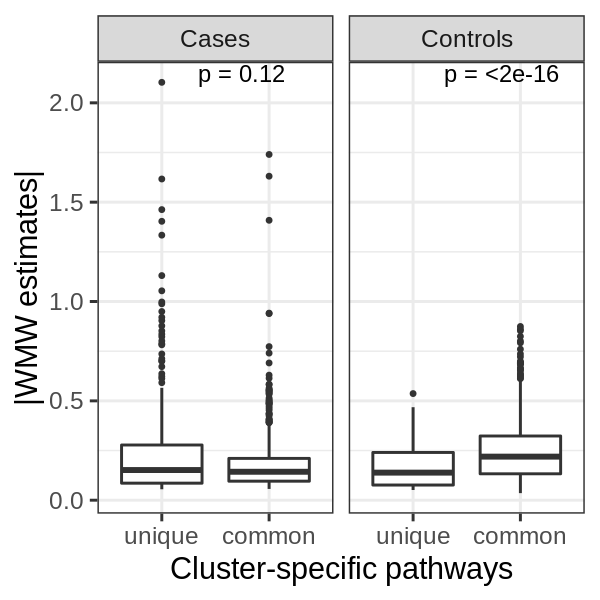

In [26]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 200)
plot_intersection(gene_cases, gene_controls_original, outFold, pval_corr_thr = 0.01, type_data = "Tscores", name_comp_controls = "ControlsOriginal", width_pl = 3, height_pl = 3)
plot_intersection(path_cases, path_controls_original, outFold, pval_corr_thr = 0.01, type_data = "Pathscores", name_comp_controls = "ControlsOriginal", width_pl = 3, height_pl = 3)

Warning message in grep("Illnesses", Field) & !is.na(meaning):
“longer object length is not a multiple of shorter object length”


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


[1] 0.95


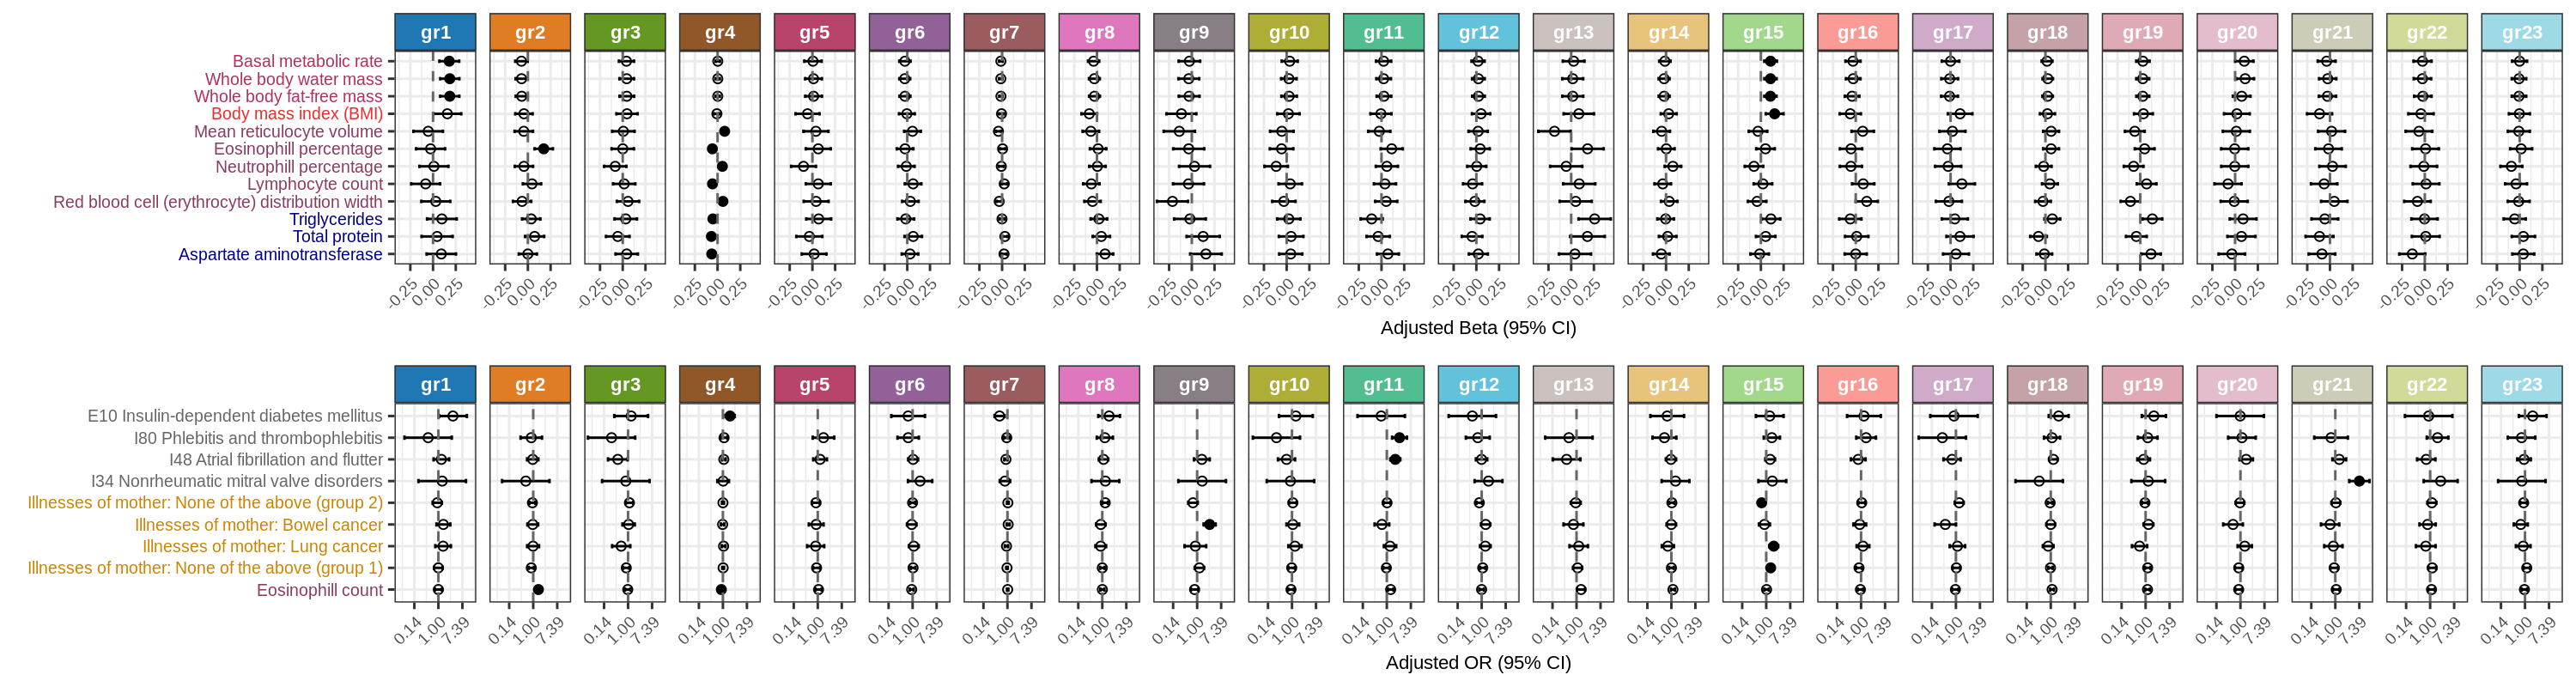

In [17]:
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 200)
endop_controls_original$CI_up <- as.numeric(endop_controls_original$CI_up)
endopheno_forest_plot(colorFile, endop_controls_original, pval_pheno = 0.0001, pval_corr_thr = 0.1, outFold, type_input = 'original', type_cluster = 'Controls')


Family_history  ICD9-10_OPCS4 
             6             39 
# A tibble: 5 × 2
  Field                      meaning                    
  <chr>                      <chr>                      
1 Aspartate aminotransferase NA                         
2 Lymphocyte count           NA                         
3 Eosinophill count          NA                         
4 Eosinophill percentage     NA                         
5 Illnesses of mother        None of the above (group 1)


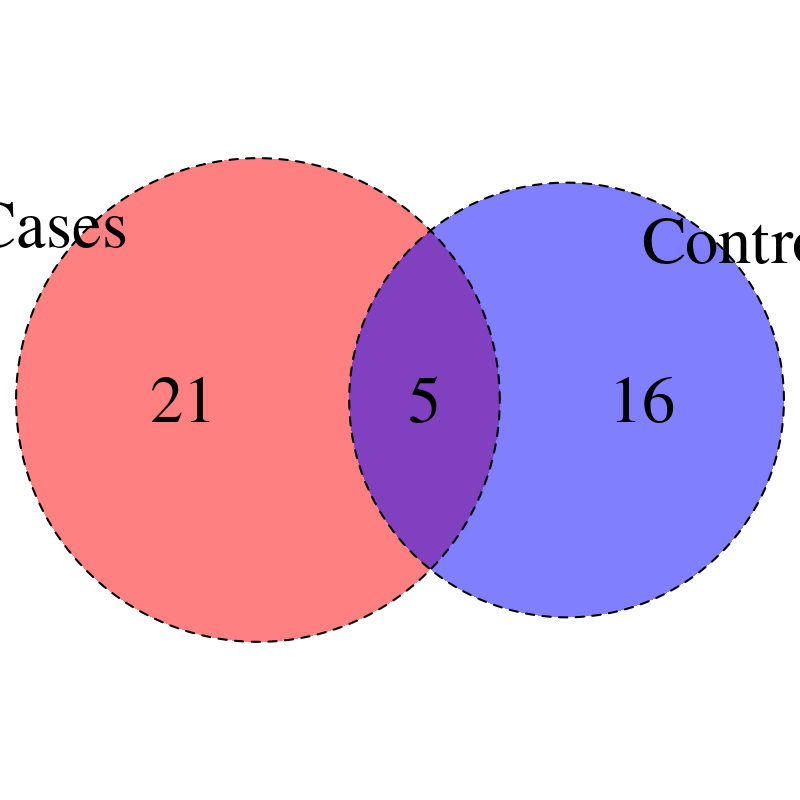

: 

In [18]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200)
plot_intersection_endop(endop_cases, endop_controls_original, outFold, pval_corr_thr = 0.1, name_comp_controls = "ControlsOriginal", width_pl = 4, height_pl = 4)

### Conclusions on cases vs controls (original) comparison:
- the number of groups is very different, the cluster quality is lower in compare
- looking and genes/pathways correlations, there is no clear assignment of controls to cases (|corr| < 0.6)
- Indeed, the number of shared genes / pathways is not high (lower than zscaled version)
- as regards endophenotypes, only 21 are in the controls compared to 26 of which 5 are in common with cases (AST and immune related ones), the overall endophenotype trend among group is not present
